Previous step before this analysis was `test_cats.ipynb`

# Imports

In [99]:
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import FoFCatalogMatching
import pycocotools.mask as mask_util
from multiprocessing import Pool
from functools import partial
# for unrec blend
from astropy.coordinates import search_around_sky, SkyCoord
from astropy.visualization import make_lupton_rgb
import astropy.units as u
from astropy.table import Table
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors


In [64]:
root_dir = os.path.expanduser('~/lsst_data/')
folder = 'annotations_lvl5'
run_name = 'lsst5_30k_4h200_bs192_ep50'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_data = pd.read_json(test_data_fn)
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")
# test_data = pd.read_json(test_data_fn)
# print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 images.


# Loading in Catalogs

## Selecting Mag Limit Truth Catalog

In [3]:
buffers = [1, 2]
mag_limits = {
    'power_law': 26.07,
    'gold': 25.3,
    'nominal': 26.42,
}

In [4]:
truth_mag_limit = mag_limits['power_law'] + buffers[0]
truth_fn = f'/u/yse2/lsst_runs/{run_name}/test_cats/test_truth_cat_maglim_{truth_mag_limit}.parquet'
# truth_fn = f'/u/yse2/lsst_runs/{run_name}/test_cats/full_test_truth_cat.parquet'
print(f'Loading LSST truth catalog from: {truth_fn}')
lsst_truth_cat = pd.read_parquet(truth_fn)

Loading LSST truth catalog from: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_cats/test_truth_cat_maglim_27.07.parquet


In [5]:
lsst_truth_cat

,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,ellipticity_2_true,size_disk_true,ellipticity_1_true,bulge_to_total_ratio_u,bulge_to_total_ratio_g,bulge_to_total_ratio_r,bulge_to_total_ratio_z,bulge_to_total_ratio_y,cutout_x,cutout_y
0,9502643055,27.678091,"6,2",18.649115,3258,26.402014,-41.221094,26.310759,3.1,53.667943,...,-0.051326,0.151395,0.146083,0.000000,0.000000,0.000000,0.000000,0.000000,31.780178,42.720967
4,9502222406,27.775291,"6,2",9.630561,3258,26.097763,-41.223223,25.817715,3.1,53.667802,...,-0.344724,0.182818,0.063776,0.086470,0.164659,0.264880,0.294759,0.309406,33.319879,4.379629
6,9502030364,27.951242,"6,2",10.324679,3258,26.439182,-41.215775,26.280909,3.1,53.663268,...,-0.149015,0.097679,0.400679,0.000000,0.000000,0.000000,0.000000,0.000000,95.980539,137.870340
8,9502312400,26.807194,"6,2",67.725174,3258,26.131615,-41.215570,26.139370,3.1,53.663637,...,0.000784,0.193863,-0.022326,0.998618,0.998662,0.998833,0.999238,0.999290,91.011997,141.601962
9,9501803150,26.748997,"6,2",67.592682,3258,26.001965,-41.218364,26.015398,3.1,53.666375,...,0.000517,0.110538,-0.003056,0.998906,0.998970,0.999184,0.999522,0.999549,53.464719,91.667167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190062,8641061146,24.977625,"3,4",410.345825,3442,25.282211,-39.281391,25.341513,3.1,51.388997,...,-0.154065,0.087027,0.177065,0.980788,0.979117,0.977786,0.977330,0.977948,94.379538,8.630151
1190063,8641062913,26.480104,"3,4",90.851982,3442,26.645918,-39.279938,26.668789,3.1,51.387510,...,0.015924,0.207814,-0.033021,0.999527,0.999591,0.999633,0.999648,0.999657,115.116449,34.766767
1190064,8641062914,25.955618,"3,4",113.467712,3442,25.851543,-39.281171,25.685822,3.1,51.388541,...,-0.036793,0.257203,-0.047946,0.979256,0.990530,0.993650,0.995977,0.996645,100.734091,12.584614
1190068,8642988273,26.797636,"3,4",57.100151,3442,27.097763,-39.277574,26.963982,3.1,51.394837,...,-0.032385,0.172873,0.035609,0.005092,0.052148,0.111276,0.170549,0.193500,13.038091,77.360720


In [82]:
counts, bin_edges = np.histogram(lsst_truth_cat[np.isfinite(lsst_truth_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
peak_mag

np.float64(26.886684894600997)

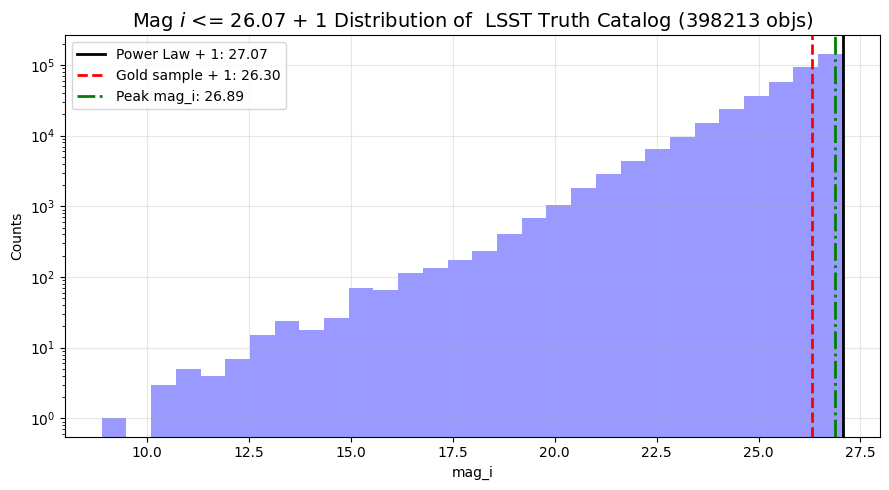

In [83]:
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(lsst_truth_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ <= 26.07 + 1 Distribution of  LSST Truth Catalog ({len(lsst_truth_cat)} objs)", fontsize=14)
plt.tight_layout()

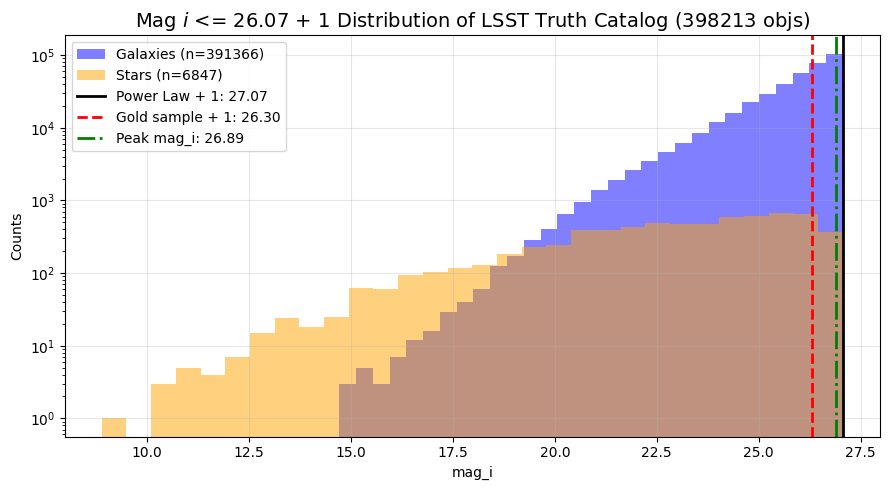

In [81]:
gals = lsst_truth_cat[lsst_truth_cat['truth_type'] == 1]
stars = lsst_truth_cat[lsst_truth_cat['truth_type'] == 2]
# peak for overall
counts, bin_edges = np.histogram(lsst_truth_cat[np.isfinite(lsst_truth_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.hist(gals['mag_i'].values, bins=30, alpha=0.5, color='blue', 
         label=f'Galaxies (n={len(gals)})', linewidth=1.5)
plt.hist(stars['mag_i'].values, bins=30, alpha=0.5, color='orange', 
         label=f'Stars (n={len(stars)})', linewidth=1.5)
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', 
            linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', 
            linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', 
            linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ <= 26.07 + 1 Distribution of LSST Truth Catalog ({len(lsst_truth_cat)} objs)", fontsize=14)
plt.tight_layout()

## LSST Detection and DeepDISC Detection Catalogs

In [6]:
with open(f'/u/yse2/lsst_runs/{run_name}/pred_with_mag_s0.45_n0.3.json', 'r') as f:
    dd_det = json.load(f)
dd_det_cat = pd.DataFrame(dd_det)
lsst_det_cat = pd.read_json(f'/u/yse2/lsst_runs/{run_name}/test_cats/test_det_cat.json')

In [18]:
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.8988113403, 17.9103298187, 65.6763458252, ...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O...",24.178501,24.361794,24.417967,24.268442,24.298439,23.601818
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.8398170471, 122.4859771729, 64.3904342651,...",0.996112,"{'size': [150, 147], 'counts': 'hk64`45L2N101N...",24.193335,24.437212,24.034464,23.551100,23.028345,22.912689
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9978141785, 41.7610740662, 77.094367981, 6...",0.994498,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10...",26.306913,26.051395,25.227131,24.238522,23.961708,23.851330
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.6843566895, 133.7820587158, 115.3896331787...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O...",26.619596,25.951719,25.406775,24.823856,24.747644,25.740545
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0695419312, 100.6748657227, 104.2363052368...",0.988882,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N...",24.696024,24.835098,24.742519,24.630798,24.255783,23.613699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237876,237876,51.387144,-39.274313,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[113.2710037231, 129.225189209, 127.2645339966...",0.630430,"{'size': [144, 147], 'counts': 'Zg`01Z45000MhK...",26.719328,27.458334,27.033850,27.349329,27.236979,25.773390
237877,237877,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.3282470703, 135.403717041, 146.8196411133...",0.527989,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}",NaN,28.596455,27.880468,27.188671,27.090696,26.914551
237878,237878,51.391806,-39.275579,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[46.381362915, 104.4423980713, 64.1989440918, ...",0.489888,"{'size': [144, 147], 'counts': 'oX76Y41O2O0000...",25.030779,24.081413,23.338036,22.997311,22.811863,22.612520
237879,237879,51.390402,-39.280363,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[67.4832687378, 19.8567733765, 82.1593093872, ...",0.458763,"{'size': [144, 147], 'counts': 'hT:6Z41O0000O2...",25.410744,25.161430,24.625507,23.838020,23.649982,23.295933


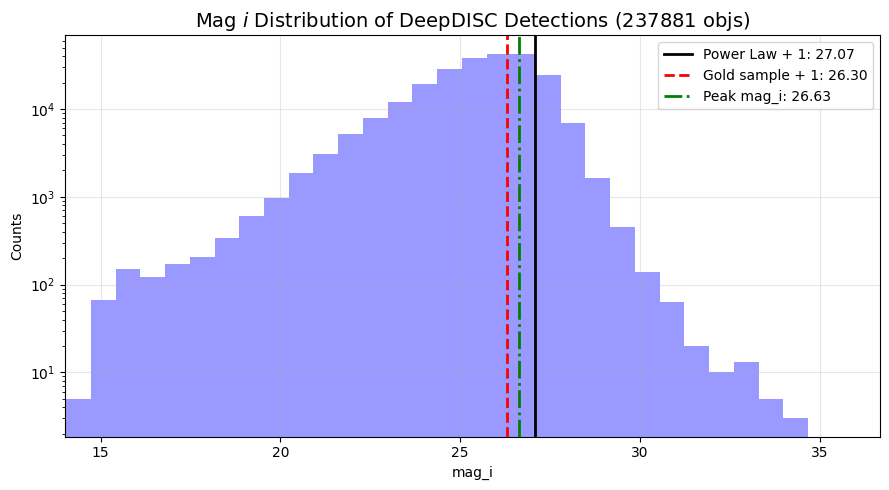

In [ ]:
counts, bin_edges = np.histogram(dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(dd_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
max_xlim = gals['mag_i'].max() + 2 if gals['mag_i'].max() > mag_limits['power_law'] + buffers[0] + 3 else mag_limits['power_law'] + buffers[0] + 3
# plt.xlim(14, max_xlim)
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of DeepDISC Detections ({len(dd_det_cat)} objs)", fontsize=14)
plt.tight_layout()

**Setting x-limits for visualization purposes**

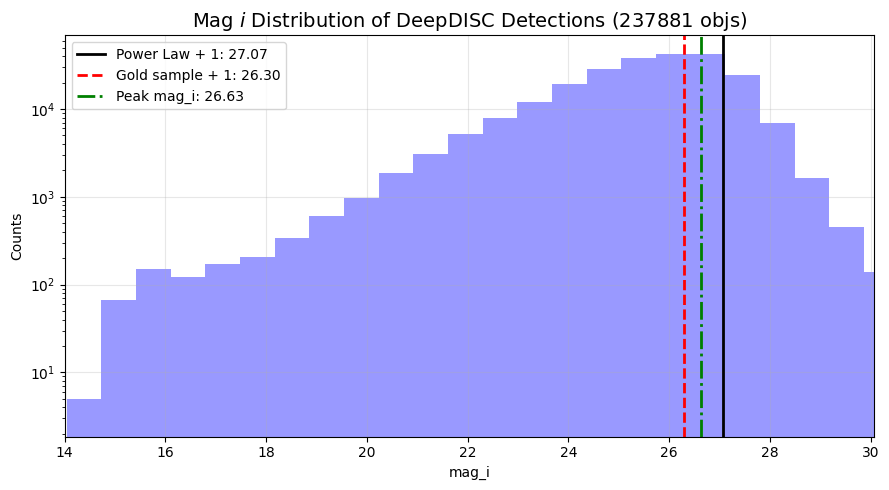

In [61]:
counts, bin_edges = np.histogram(dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(dd_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.xlim(14, mag_limits['power_law'] + buffers[0] + 3)
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of DeepDISC Detections ({len(dd_det_cat)} objs)", fontsize=14)
plt.tight_layout()

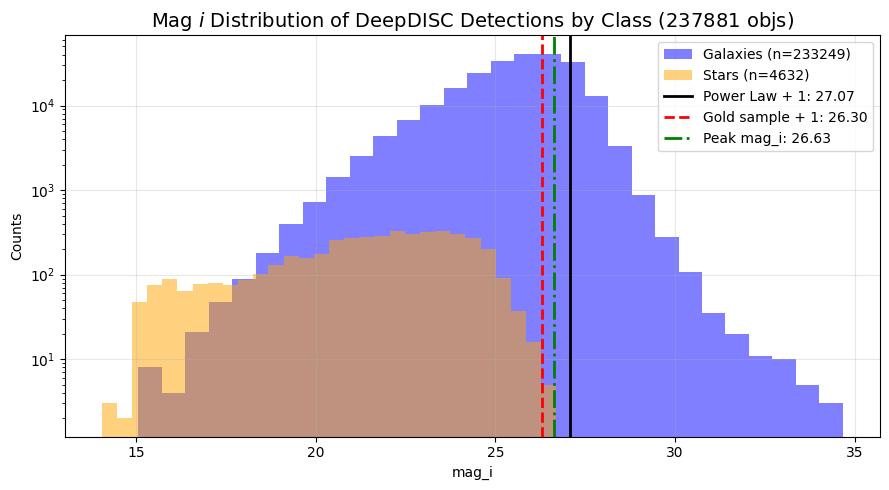

In [60]:
gals = dd_det_cat[dd_det_cat['class'] == 0]
stars = dd_det_cat[dd_det_cat['class'] == 1]
# peak for overall
counts, bin_edges = np.histogram(dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.hist(gals['mag_i'].values, bins=30, alpha=0.5, color='blue', 
         label=f'Galaxies (n={len(gals)})', linewidth=1.5)
plt.hist(stars['mag_i'].values, bins=30, alpha=0.5, color='orange', 
         label=f'Stars (n={len(stars)})', linewidth=1.5)
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', 
            linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', 
            linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', 
            linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.xlabel('mag_i')
# max_xlim = gals['mag_i'].max() + 2 if gals['mag_i'].max() > mag_limits['power_law'] + buffers[0] + 3 else mag_limits['power_law'] + buffers[0] + 3
# plt.xlim(14, max_xlim)
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of DeepDISC Detections by Class ({len(dd_det_cat)} objs)", fontsize=14)
plt.tight_layout()

**Setting x-limits for visualization purposes**

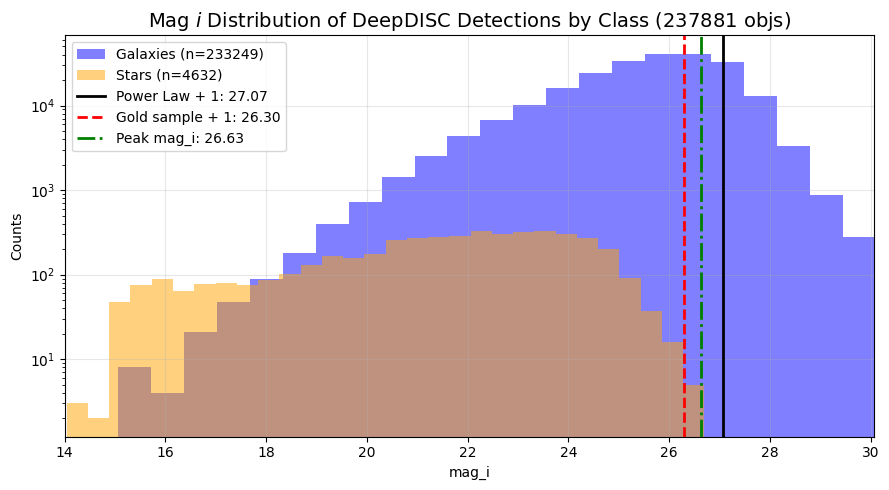

In [54]:
gals = dd_det_cat[dd_det_cat['class'] == 0]
stars = dd_det_cat[dd_det_cat['class'] == 1]
# peak for overall
counts, bin_edges = np.histogram(dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.hist(gals['mag_i'].values, bins=30, alpha=0.5, color='blue', 
         label=f'Galaxies (n={len(gals)})', linewidth=1.5)
plt.hist(stars['mag_i'].values, bins=30, alpha=0.5, color='orange', 
         label=f'Stars (n={len(stars)})', linewidth=1.5)
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', 
            linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', 
            linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', 
            linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.xlabel('mag_i')
# max_xlim = gals['mag_i'].max() + 2 if gals['mag_i'].max() > mag_limits['power_law'] + buffers[0] + 3 else mag_limits['power_law'] + buffers[0] + 3
plt.xlim(14, mag_limits['power_law'] + buffers[0] + 3)
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of DeepDISC Detections by Class ({len(dd_det_cat)} objs)", fontsize=14)
plt.tight_layout()

In [19]:
lsst_det_cat

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,...,mag_r,tract,mag_u_cModel,psf_fwhm_g,snr_g_cModel,psf_fwhm_y,ra,mag_i,cutout_x,cutout_y
0,True,26.054455,0.839360,"6,2",26.391528,1.372450,7.986091,0.0,25.115672,26.035569,...,26.635976,3258,26.065832,0.906069,8.217093,1.196548,53.668989,25.714607,17.345009,13.694152
1,True,26.667179,0.836192,"6,2",28.294721,0.410546,5.409555,1.0,26.385419,31.735020,...,27.463185,3258,31.225104,0.897965,1.592505,1.195475,53.667857,26.146065,32.921703,41.108337
2,True,23.936885,0.833364,"6,2",26.123854,6.848957,30.585702,1.0,23.963736,26.357919,...,25.257772,3258,26.248074,0.906053,10.749887,1.196572,53.665341,24.252631,67.101120,51.863405
3,True,23.860131,0.833865,"6,2",25.951169,8.531146,15.419505,1.0,23.792243,25.744292,...,25.765215,3258,25.124282,0.906057,14.465168,1.196555,53.667098,25.096791,43.344833,56.889773
4,True,NaN,0.836197,"6,2",25.781982,-0.727757,6.410049,1.0,26.214673,26.471734,...,26.108692,3258,26.072404,0.906063,15.084706,1.195475,53.669548,26.019545,10.137120,53.655391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270102,True,26.132345,0.837439,"3,4",26.312939,0.948628,3.461150,1.0,27.125819,26.967916,...,26.456067,3442,26.986949,0.898018,9.449028,1.154099,51.388617,26.588257,99.732485,120.612650
270103,True,24.768463,0.839339,"3,4",25.539306,3.527315,11.364457,1.0,25.243289,25.266529,...,25.536465,3442,25.255952,0.911635,18.806127,1.154135,51.393820,25.338946,27.236805,126.068411
270104,True,30.346829,0.839340,"3,4",26.752295,NaN,4.967199,1.0,NaN,26.895290,...,27.009309,3442,26.771803,0.911641,6.316508,1.157728,51.393556,26.246633,30.909927,133.631957
270105,True,NaN,0.839339,"3,4",26.888039,NaN,3.755131,1.0,25.989924,NaN,...,26.689888,3442,NaN,0.911639,5.585058,1.157728,51.393251,26.532202,35.168190,127.239282


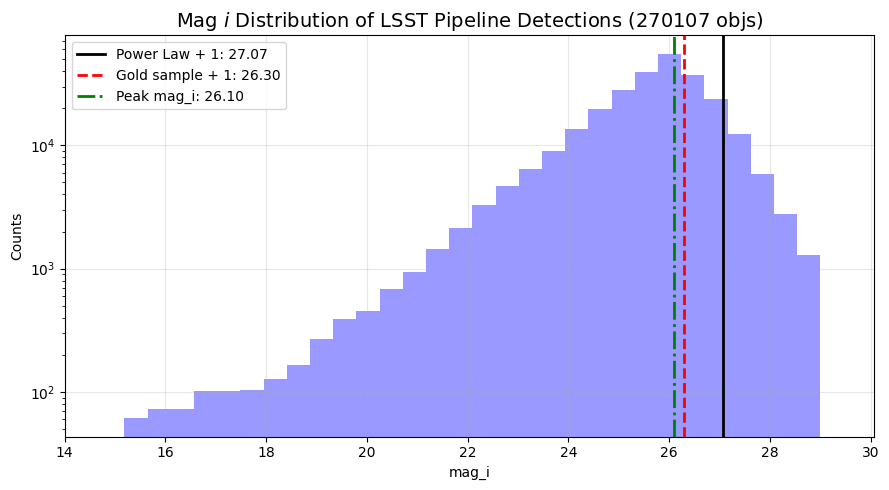

In [46]:
counts, bin_edges = np.histogram(lsst_det_cat[np.isfinite(lsst_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(lsst_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.xlim(14, mag_limits['power_law'] + buffers[0] + 3)
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of LSST Pipeline Detections ({len(lsst_det_cat)} objs)", fontsize=14)
plt.tight_layout()

In [34]:
lsst_det_cat.extendedness.value_counts()

extendedness
1.0    208732
0.0     59207
Name: count, dtype: int64

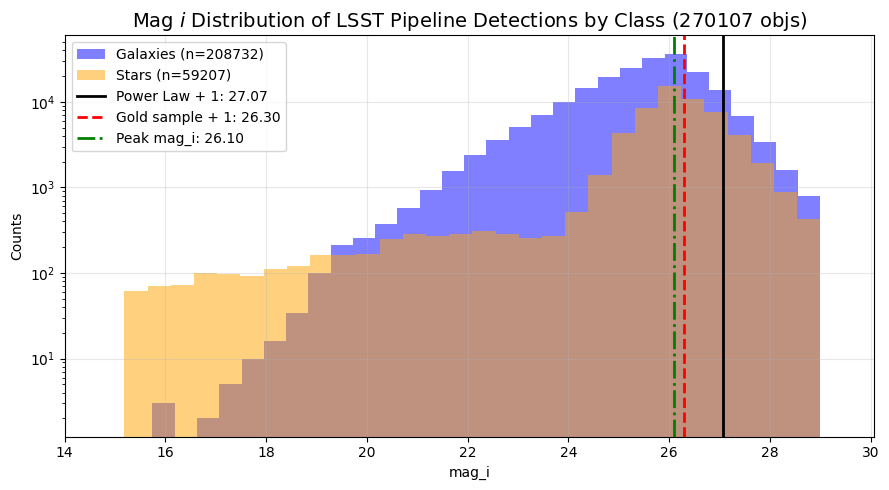

In [45]:
gals = lsst_det_cat[lsst_det_cat['extendedness'] == 1]
stars = lsst_det_cat[lsst_det_cat['extendedness'] == 0]
# peak for overall
counts, bin_edges = np.histogram(lsst_det_cat[np.isfinite(lsst_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.hist(gals['mag_i'].values, bins=30, alpha=0.5, color='blue', 
         label=f'Galaxies (n={len(gals)})', linewidth=1.5)
plt.hist(stars['mag_i'].values, bins=30, alpha=0.5, color='orange', 
         label=f'Stars (n={len(stars)})', linewidth=1.5)
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', 
            linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', 
            linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', 
            linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.xlabel('mag_i')
plt.xlim(14, mag_limits['power_law'] + buffers[0] + 3)
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of LSST Pipeline Detections by Class ({len(lsst_det_cat)} objs)", fontsize=14)
plt.tight_layout()

# Cross-Matching Detection and Truth Catalogs for Completeness

The below criteria is loosely based on Troxel 2023 et al. selection criteria in 5.1.

To be considered a "valid" detection (recovered from the truth catalog), the source must meet these two criteria:
- Detection must be within 1" of a truth object
- If multiple truth objects are within 1", the match is assigned to the truth object that is the closest in magnitude (considering all nearest neighbors).

To achieve this, we will use `search_around_sky` which will find all the matches within a given radius. Then, we group all the truth matches for the same detection and sort them based on the detection's observed mag and the truth match's mag. Since it's all sorted now, to keep the best match, we simply drop all the duplicates and keep the first occurrence.

In [18]:
def match_with_truth(det_cat, truth_cat, max_sep=1.0*u.arcsec, det_mag_col='mag_i', truth_mag_col='mag_i'):
    """
    Match detection catalog with truth catalog with search around sky within max_sep
    Parameters:
    -----------
    det_cat: pd.DataFrame
        Detection catalog with minimum 'ra' and 'dec' columns in degrees
    truth_cat: pd.DataFrame
        Truth catalog with minimum 'ra' and 'dec' columns in degrees
    det_mag_col: str
        detection catalog mag column name to consider for matching (default 'mag_i')
    truth_mag_col: str
        truth catalog mag column name to consider for matching (default 'mag_i')
    max_sep: astropy.units.Quantity
        Maximum separation for matching (default 1 arcsec)
    Returns:
    --------
    matched_det: pd.DataFrame
        Matched detection catalog
    matched_truth: pd.DataFrame
        Matched truth catalog
    """
    if len(det_cat) == 0:
        return pd.DataFrame(), pd.DataFrame()
    det_coords = SkyCoord(ra=det_cat['ra'].values*u.deg, 
                         dec=det_cat['dec'].values*u.deg)
    truth_coords = SkyCoord(ra=truth_cat['ra'].values*u.deg, 
                           dec=truth_cat['dec'].values*u.deg)
    idx_truth, idx_det, d2d, _ = det_coords.search_around_sky(truth_coords, max_sep)
    if len(idx_det) == 0:
        print(f"No matches found within the separation of {max_sep}")
        return pd.DataFrame(), pd.DataFrame()
    # turn into a df so we can easily filter and sort
    det_mag_is = det_cat[det_mag_col].values
    truth_mag_is = truth_cat[truth_mag_col].values
    matches = pd.DataFrame({
        'det_idx': idx_det,
        'truth_idx': idx_truth,
        'sep_arcsec': d2d.arcsec,
        'det_mag_i': det_mag_is[idx_det],
        'truth_mag_i': truth_mag_is[idx_truth],
    })
    matches['mag_i_diff'] = np.abs(matches['det_mag_i'] - matches['truth_mag_i'])
    # sort candidates by three keys: 
    # det_idx (grouping matches for the same detection together)
    # mag_diff (now within each det group, sort leaving smallest diff first)
    # sep_arcsec (if two truth objs have same mag_diff, we use tie-breaker: sort leaving smallest sep first)
    sorted_matches = matches.sort_values(['det_idx', 'mag_i_diff', 'sep_arcsec'])
    # now we have the "best" match for each det (closest in mag_i, then closest in sep)
    # so we drop duplicates keeping first occurrence (mag priority criteria)
    final_matches = sorted_matches.drop_duplicates(subset=['det_idx'], keep='first')
    # get matched rows from OG catalogs and we reset index so the dfs align and we don't need the old indices
    matched_det = det_cat.iloc[final_matches['det_idx']].reset_index(drop=True)
    matched_truth = truth_cat.iloc[final_matches['truth_idx']].reset_index(drop=True)
    
    matched_det['match_sep_arcsec'] = final_matches['sep_arcsec'].values
    matched_det['mag_i_diff'] = final_matches['mag_i_diff'].values
    print(f"With {max_sep}\": Found {len(matched_det)} matched pairs out of {len(truth_coords)} truth objs in the truth catalog.\n")
    return matched_det, matched_truth

In [ ]:
matched_dd_det_sep05, matched_dd_lsst_truth_sep05 = match_with_truth(dd_det_cat, lsst_truth_cat, max_sep=0.5*u.arcsec)
matched_dd_det_sep1, matched_dd_lsst_truth_sep1 = match_with_truth(dd_det_cat, lsst_truth_cat) # 2.5s for both matches

With 0.5 arcsec": Found 208246 matched pairs out of 398213 truth objs in the truth catalog.

With 1.0 arcsec": Found 225680 matched pairs out of 398213 truth objs in the truth catalog.



In [180]:
matched_dd_det_sep05.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_dd_det05.json')
matched_dd_det_sep1.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_dd_det1.json')
matched_dd_lsst_truth_sep05.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_dd_lsst_truth05.json')
matched_dd_lsst_truth_sep1.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_dd_lsst_truth1.json')

In [ ]:
matched_lsst_det_sep05, matched_det_lsst_truth_sep05 = match_with_truth(lsst_det_cat, lsst_truth_cat, max_sep=0.5*u.arcsec) # 1.5s
matched_lsst_det_sep1, matched_det_lsst_truth_sep1 = match_with_truth(lsst_det_cat, lsst_truth_cat)

With 0.5 arcsec": Found 242246 matched pairs out of 398213 truth objs in the truth catalog.

With 1.0 arcsec": Found 247192 matched pairs out of 398213 truth objs in the truth catalog.



In [181]:
matched_lsst_det_sep05.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_lsst_det05.json')
matched_lsst_det_sep1.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_lsst_det1.json')
matched_det_lsst_truth_sep05.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_det_lsst_truth05.json')
matched_det_lsst_truth_sep1.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_cats/matched_det_lsst_truth1.json')

## Visualize a DeepDISC-LSST Truth Match

In [66]:
img = np.load(matched_dd_det_sep05.iloc[0]['file_name']) # i-band
matched_dd_det_sep05.iloc[0]['file_name']

'/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_-41.1.npy'

In [ ]:
r = img[3, :, :] # i
g = img[2, :, :] # r
b = img[1, :, :] # g
pmin = np.percentile([r, g, b], 1)
pmax = np.percentile([r, g, b], 99.5)
stretch = pmax - pmin # ~27.160368
vis_img = make_lupton_rgb(r, g, b, minimum=pmin, stretch=stretch, Q=10)
obj_x = matched_dd_lsst_truth_sep05.iloc[0]['cutout_x']
obj_y = matched_dd_lsst_truth_sep05.iloc[0]['cutout_y']

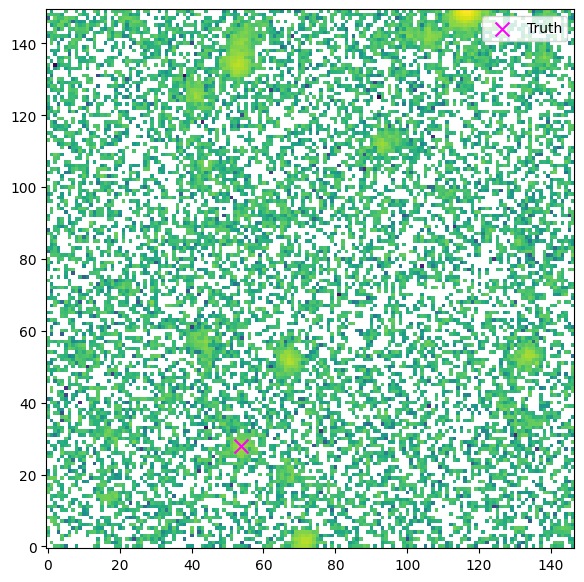

In [76]:
plt.figure(figsize=(7,7))
plt.imshow(r, origin='lower', norm=colors.LogNorm())
# plt.imshow(vis_img, origin='lower')
plt.scatter(obj_x, obj_y, marker='x', s=100, c='magenta', label='Truth')
plt.legend()

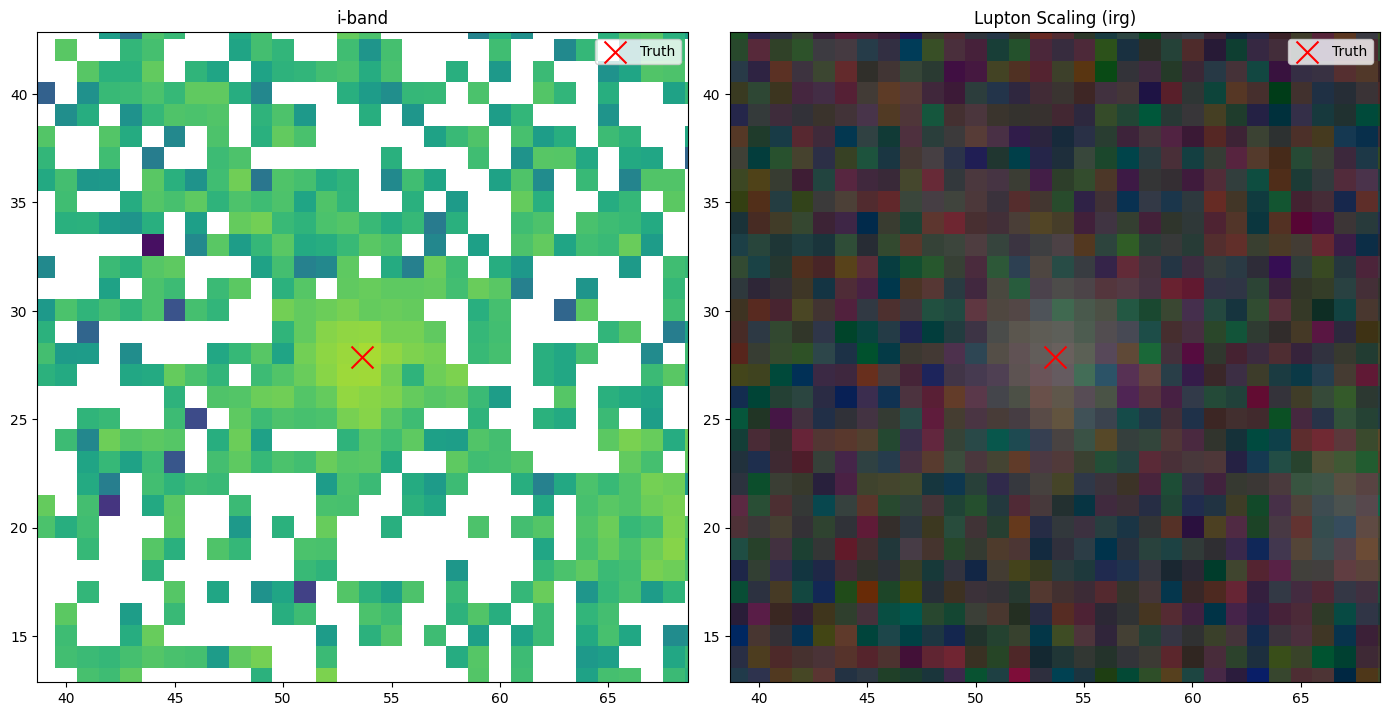

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(r, origin='lower', norm=colors.LogNorm())
axes[0].set_xlim(obj_x - 15, obj_x + 15)
axes[0].set_ylim(obj_y - 15, obj_y + 15)
axes[0].scatter(obj_x, obj_y, marker='x', s=250, c='red', label='Truth')
axes[0].legend()
axes[0].set_title('i-band')
# Right plot: RGB composite
axes[1].imshow(vis_img, origin='lower')
axes[1].set_xlim(obj_x - 15, obj_x + 15)
axes[1].set_ylim(obj_y - 15, obj_y + 15)
axes[1].scatter(obj_x, obj_y, marker='x', s=250, c='red', label='Truth')
axes[1].legend()
axes[1].set_title('Lupton Scaling (irg)')
plt.tight_layout()

# Detection Completeness

In [170]:
def calc_comp_bootstrap(full_truth_cat, matched_truth_cat,
                                     mag_col='mag_i',
                                     bins=np.linspace(18, mag_limits["power_law"] + buffers[0], 30), 
                                     n_boot=1000,
                                     confidence_lvl=0.95, 
                                     seed=42):
    """
    Calculate detection completeness w/ bootstrap errors
    
    Parameters:
    -----------
    full_truth_cat : pd.DataFrame
        The complete truth catalog (denominator)
    matched_truth_cat : pd.DataFrame
        Truth objects that were successfully matched/detected (numerator)
    mag_col : str
        Name of mag column to use
    bins : array-like
        The mag bin edges
    n_boot : int
        Number of bootstrap iterations
    confidence_lvl: float
        Confidence Interval (0-1). 1-sigma: 68%, 2-sigma: 95%, 3-sigma: 99.5%
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict
        Dictionary containing bin_centers, completeness, and error arrays
    """
    np.random.seed(seed)
    # we first need to flag detected objs in full catalog
    # We know that id is a unique identifier in the truth catalog 
    # so we use this to create a set
    detected_ids = set(matched_truth_cat['id'].values)
    # tmp df from truth to avoid modifying the original
    tmp = pd.DataFrame({
        'mag': full_truth_cat[mag_col].values,
        'id': full_truth_cat['id'].values
    })
    # flag for det (since id doesn't depend on the indices of the df, we won't have to work with .index anymore)
    tmp['is_detected'] = tmp['id'].apply(lambda x: x in detected_ids)
    truth_hist, _ = np.histogram(tmp['mag'], bins=bins)
    det_hist, _ = np.histogram(tmp[tmp['is_detected']]['mag'], bins=bins)
    #  ignore division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        completeness = det_hist / truth_hist

    # now let's do bootstrap resampling 
    # by resampling the population of truth objects to estimate variance
    boot_comp_list = []
    # pre-calc bin idxs for speed
    # digitize returns bin idx for each obj (0 to len(bins))
    bin_idxs = np.digitize(tmp['mag'], bins)
    # filter out objs outside bins
    valid_mask = (bin_idxs > 0) & (bin_idxs < len(bins))
    valid_df = tmp[valid_mask].copy()
    valid_df['bin_idx'] = bin_idxs[valid_mask] - 1 # 0-based idx
    n_bins = len(bins) - 1
    for i in range(n_boot):
        if i % 100 == 0:
            print(f"Bootstrap sample {i}/{n_boot}")
        # resample idxs w/ replacement
        resampled_idxs = np.random.randint(0, len(valid_df), len(valid_df))
        resampled_df = valid_df.iloc[resampled_idxs]
        # group by bin and count detected vs total
        # and use agg since it's pretty fast
        grouped = resampled_df.groupby('bin_idx')['is_detected'].agg(['sum', 'count'])
        # are all bins represented?
        boot_res = np.zeros(n_bins)
        # now we gotta map results to correct bins (some bins might be empty in this sample)
        # idxs present in grouped
        present_bins = grouped.index.values
        ratios = grouped['sum'] / grouped['count']
        boot_res[present_bins] = ratios.values
        # find bins that had 0 counts in this iteration and set to NaN
        # so they don't skew our mean with 0s
        # 'count' is strictly > 0 for present groups
        # bins not present in 'grouped' are effectively 0/0 = NaN.
        boot_res[~np.isin(np.arange(n_bins), present_bins)] = np.nan
        boot_comp_list.append(boot_res)
        
    boot_comp_arr = np.array(boot_comp_list)
    # percentiles for error bars based on conf level
    alpha = 1.0 - confidence_lvl
    p_low = (alpha / 2.0) * 100
    p_high = (1.0 - alpha / 2.0) * 100
    # nanpercentile handles empty bins safely
    comp_low = np.nanpercentile(boot_comp_arr, p_low, axis=0)
    comp_high = np.nanpercentile(boot_comp_arr, p_high, axis=0)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    return {
        'bin_centers': bin_centers,
        'completeness': completeness,
        'err_low': completeness - comp_low,
        'err_high': comp_high - completeness,
        'confidence_lvl': confidence_lvl
    }

def calculate_comp_by_class(full_truth_cat, matched_truth_cat, 
                            class_col='truth_type',
                            class_map={1: 'Galaxy', 2: 'Star'},
                            mag_col='mag_i',
                            bins=np.linspace(18, mag_limits["power_law"] + buffers[0], 30), 
                            n_boot=100,
                            confidence_lvl=0.95):
    """
    Just a wrapper to calculate stats by class w/ a  confidence level
    """
    results = {}
    for code, label in class_map.items():
        print(f"Processing class: {label} ({code})...")
        subset_full = full_truth_cat[full_truth_cat[class_col] == code]
        subset_matched = matched_truth_cat[matched_truth_cat[class_col] == code]
        if len(subset_full) == 0:
            print(f"  Warning: No truth objects found for class {label}")
            continue
        stats = calc_comp_bootstrap(
            full_truth_cat=subset_full,
            matched_truth_cat=subset_matched,
            mag_col=mag_col,
            bins=bins,
            n_boot=n_boot,
            confidence_lvl=confidence_lvl
        )
        results[label] = stats
    return results

## DeepDISC DC (By Class, Matching Radius)

In [ ]:
# 1m 37s
print("0.5\" sep: Calcuating DeepDISC Completeness as a function of mag_i for all objs")
dd_stats05 = calc_comp_bootstrap(
    full_truth_cat=lsst_truth_cat, 
    matched_truth_cat=matched_dd_lsst_truth_sep05, 
    mag_col='mag_i',
    n_boot=1000
)
print("\n0.5\" sep: Calcuating DeepDISC Completeness by class as a function of mag_i")
dd_class_stats05 = calculate_comp_by_class(
    full_truth_cat=lsst_truth_cat,
    matched_truth_cat=matched_dd_lsst_truth_sep05,
    class_col='truth_type',
    class_map={1: 'Galaxy', 2: 'Star'},
    mag_col='mag_i',
    n_boot=1000
)
print("1.0\" sep: Calcuating DeepDISC Completeness as a function of mag_i for all objs")
dd_stats1 = calc_comp_bootstrap(
    full_truth_cat=lsst_truth_cat, 
    matched_truth_cat=matched_dd_lsst_truth_sep1, 
    mag_col='mag_i',
    n_boot=1000
)
print("\n1.0\" sep: Calcuating DeepDISC Completeness by class as a function of mag_i")
dd_class_stats1 = calculate_comp_by_class(
    full_truth_cat=lsst_truth_cat,
    matched_truth_cat=matched_dd_lsst_truth_sep1,
    class_col='truth_type',
    class_map={1: 'Galaxy', 2: 'Star'},
    mag_col='mag_i',
    n_boot=1000
)

0.5" sep: Calcuating DeepDISC Completeness as a function of mag_i for all objs
Bootstrap sample 0/1000
Bootstrap sample 100/1000
Bootstrap sample 200/1000
Bootstrap sample 300/1000
Bootstrap sample 400/1000
Bootstrap sample 500/1000
Bootstrap sample 600/1000
Bootstrap sample 700/1000
Bootstrap sample 800/1000
Bootstrap sample 900/1000

0.5" sep: Calcuating DeepDISC Completeness by class as a function of mag_i
Processing class: Galaxy (1)...
Bootstrap sample 0/1000
Bootstrap sample 100/1000
Bootstrap sample 200/1000
Bootstrap sample 300/1000
Bootstrap sample 400/1000
Bootstrap sample 500/1000
Bootstrap sample 600/1000
Bootstrap sample 700/1000
Bootstrap sample 800/1000
Bootstrap sample 900/1000
Processing class: Star (2)...
Bootstrap sample 0/1000
Bootstrap sample 100/1000
Bootstrap sample 200/1000
Bootstrap sample 300/1000
Bootstrap sample 400/1000
Bootstrap sample 500/1000
Bootstrap sample 600/1000
Bootstrap sample 700/1000
Bootstrap sample 800/1000
Bootstrap sample 900/1000
1.0" sep:

## LSST Pipeline DC (By Class, Matching Radius)

In [ ]:
print("0.5\" sep: Calcuating LSST Pipeline Completeness as a function of mag_i for all objs")
lsst_stats05 = calc_comp_bootstrap(
    full_truth_cat=lsst_truth_cat, 
    matched_truth_cat=matched_det_lsst_truth_sep05, 
    mag_col='mag_i',
    n_boot=1000
)
print("\n0.5\" sep: Calcuating LSST Pipeline Completeness by class as a function of mag_i")
lsst_class_stats05 = calculate_comp_by_class(
    full_truth_cat=lsst_truth_cat,
    matched_truth_cat=matched_det_lsst_truth_sep05,
    class_col='truth_type',
    class_map={1: 'Galaxy', 2: 'Star'},
    mag_col='mag_i',
    n_boot=1000
)
print("1.0\" sep: Calcuating LSST Pipeline Completeness as a function of mag_i for all objs")
lsst_stats1 = calc_comp_bootstrap(
    full_truth_cat=lsst_truth_cat, 
    matched_truth_cat=matched_det_lsst_truth_sep1, 
    mag_col='mag_i',
    n_boot=1000
)
print("\n1.0\" sep: Calcuating LSST Pipeline Completeness by class as a function of mag_i")
lsst_class_stats1 = calculate_comp_by_class(
    full_truth_cat=lsst_truth_cat,
    matched_truth_cat=matched_det_lsst_truth_sep1,
    class_col='truth_type',
    class_map={1: 'Galaxy', 2: 'Star'},
    mag_col='mag_i',
    n_boot=1000
)

0.5" sep: Calcuating LSST Pipeline Completeness as a function of mag_i for all objs
Bootstrap sample 0/1000
Bootstrap sample 100/1000
Bootstrap sample 200/1000
Bootstrap sample 300/1000
Bootstrap sample 400/1000
Bootstrap sample 500/1000
Bootstrap sample 600/1000
Bootstrap sample 700/1000
Bootstrap sample 800/1000
Bootstrap sample 900/1000

0.5" sep: Calcuating LSST Pipeline Completeness by class as a function of mag_i
Processing class: Galaxy (1)...
Bootstrap sample 0/1000
Bootstrap sample 100/1000
Bootstrap sample 200/1000
Bootstrap sample 300/1000
Bootstrap sample 400/1000
Bootstrap sample 500/1000
Bootstrap sample 600/1000
Bootstrap sample 700/1000
Bootstrap sample 800/1000
Bootstrap sample 900/1000
Processing class: Star (2)...
Bootstrap sample 0/1000
Bootstrap sample 100/1000
Bootstrap sample 200/1000
Bootstrap sample 300/1000
Bootstrap sample 400/1000
Bootstrap sample 500/1000
Bootstrap sample 600/1000
Bootstrap sample 700/1000
Bootstrap sample 800/1000
Bootstrap sample 900/1000

In [171]:
def print_comp_summary(stats):
    """
    Prints a summary table of completeness percentages per bin.
    
    Parameters:
    -----------
    stats : dict
        Output from either calculate_comp_bootstrap (single dict)
        or calculate_comp_by_class (dict of dicts).
    """
    # Handle both single-stat and multi-class inputs
    if 'bin_centers' in stats:
        # single stats object (e.g., from all objects)
        data_to_print = {'All Objects': stats}
    else:
        # dictionary of classes (e.g., {'Galaxy': ..., 'Star': ...})
        data_to_print = stats
    
    for label, stats in data_to_print.items():
        print(f"----------------------------------------")
        print(f" COMPLETENESS SUMMARY: {label.upper()}")
        print(f"----------------------------------------")
        centers = stats['bin_centers']
        comp = stats['completeness']
        err_low = stats['err_low']
        err_high = stats['err_high']
        # Infer bin width to show ranges (assuming roughly equal spacing)
        if len(centers) > 1:
            half_width = (centers[1] - centers[0]) / 2
        else:
            half_width = 0.25 # Default fallback
        print(f"{'Mag Range':<15} | {'Comp (%)':<10} | {'Error (-/+)':<20}")
        print("-" * 50)
        for i in range(len(centers)):
            # bin edges for display
            m_min = centers[i] - half_width
            m_max = centers[i] + half_width
            range_str = f"{m_min:.2f}-{m_max:.2f}"
            val = comp[i] * 100
            e_low = err_low[i] * 100
            e_high = err_high[i] * 100
            if np.isnan(val):
                print(f"{range_str:<15} | {'N/A':<10} | {'--':<20}")
            else:
                print(f"{range_str:<15} | {val:6.2f}%    | -{e_low:5.2f}% / +{e_high:5.2f}%")
        print("\n")

## Plotting DC Curves

In [ ]:
def plot_det_comp(
    main_data, 
    comp_data=None,
    full_truth_cat=None, 
    mag_col='mag_i',
    class_col='truth_type',
    class_map={1: 'Galaxy', 2: 'Star'},
    main_label='Main',
    comp_label='Comparison',
    title='Detection Completeness',
    show_err_bars=False, 
    show_err_bands=True, 
    show_hist=True,
    ax=None,
    cmap_name='tab10',
    legend_loc='upper left'
):
    """
    Handles:
    1. Single population (All objects)
    2. Multiple classes (Stars vs Galaxies)
    3. Method comparison (Method A vs Method B like 0.5" vs 1.0") 
    4. Method comparison by class (Method A Galaxies vs Method B Galaxies, etc.)
    
    Parameters:
    -----------
    main_data : dict
        Either a single stats dict (from calc_comp_bootstrap) 
        OR a dict of stats dicts (from calc_comp_bootstrap).
    comp_data : dict, optional
        Data to compare against (e.g., LSST pipeline results). 
        Must have same structure as main_data
    full_truth_cat : pd.DataFrame, optional
        Truth catalog for background histograms
    mag_col : str
        Magnitude column name.
    class_col : str
        Truth type column name (for filtering histograms)
    class_map : dict
        Mapping of truth type codes to labels (for filtering histograms)
    main_label : str
        Label for main_data (e.g., "DeepDISC")
    comp_label : str
        Label for comp_data (e.g., "LSST Pipeline")
    title : str
        Plot title
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
        
    # normalizing inputs
    # Convert single stats dict to {'All': stats} for uniform processing
    if 'bin_centers' in main_data:
        # single stats obj
        processed_main = {'All': main_data}
        is_multi_class = False
    else:
        # already a dict of classes
        processed_main = main_data
        is_multi_class = True
        
    processed_comp = {}
    if comp_data is not None:
        if 'bin_centers' in comp_data:
            processed_comp = {'All': comp_data}
        else:
            processed_comp = comp_data

    # --- 2. Setup Colors and Styles ---
    classes = list(processed_main.keys())
    n_curves = max(1, len(classes))
    
    def get_color_palette(label, n):
        """Returns a list of n colors based on label"""
        if 'DeepDISC' in label:
            # shades of Blue (avoiding very light whites at the start)
            return plt.cm.Blues(np.linspace(0.6, 1.0, n))
        elif 'LSST' in label:
            # shades of Red
            return plt.cm.Greens(np.linspace(0.6, 1.0, n))
        else:
            # Default fallback
            return plt.cm.get_cmap(cmap_name).resampled(n)(np.arange(n))
    # Generate color lists for main and comparison
    main_colors = get_color_palette(main_label, n_curves)
    # For comparison, we check comp_label. If it's None/Empty, we won't use it.
    comp_colors = get_color_palette(comp_label, n_curves) if comp_data else []
    
    # helper func to plot a single series
    def _plot_series(ax, stats, color, lbl, linestyle='-', marker='o'):
        x = stats['bin_centers']
        y = stats['completeness']
        err_low = stats['err_low']
        err_high = stats['err_high']
        ax.plot(x, y, linestyle=linestyle, marker=marker, color=color, label=lbl, linewidth=2)
        if show_err_bars:
            ax.errorbar(x, y, yerr=[err_low, err_high], fmt='none', 
                        ecolor=color, capsize=3, alpha=0.8)
        if show_err_bands:
            ax.fill_between(x, y - err_low, y + err_high, 
                            color=color, alpha=0.15)

    # --- 3. Iterate and Plot Curves ---
    for i, class_name in enumerate(classes):
        c_main = main_colors[i]
        # What Label?
        # If comparing methods, label needs Method name + class. 
        # If single method, just class name
        # If single method AND single class, just Method name.
        if comp_data is None:
            lbl_main = class_name if is_multi_class else main_label
        else:
            lbl_main = f"{main_label} ({class_name})" if is_multi_class else main_label
        # plotting main data (Solid Line)
        stats_main = processed_main[class_name]
        _plot_series(ax, stats_main, c_main, lbl_main, linestyle='-', marker='o')
        # plotting comparison data (Dashed Line)
        if class_name in processed_comp:
            stats_comp = processed_comp[class_name]
            c_comp = comp_colors[i]
            if is_multi_class:
                lbl_comp = f"{comp_label} ({class_name})"
            else:
                lbl_comp = comp_label
            # same color but dashed
            _plot_series(ax, stats_comp, c_comp, lbl_comp, linestyle='--', marker='s')

    # --- 4. Plot Background Histogram ---
    if show_hist and full_truth_cat is not None:
        ax2 = ax.twinx()
        # hist bins based on the first stats obj
        first_stats = list(processed_main.values())[0]
        hist_bins = np.linspace(first_stats['bin_centers'][0]-0.5, 
                                first_stats['bin_centers'][-1]+0.5, 
                                len(first_stats['bin_centers'])+1)
        max_count = 0
        # inverting class_map to find code from name
        name_to_code = {v: k for k, v in class_map.items()}
        for i, class_name in enumerate(classes):
            if not is_multi_class:
                # plot all objs
                subset = full_truth_cat
                c_hist = 'gray'
            else:
                # filter by class
                if class_name in name_to_code:
                    code = name_to_code[class_name]
                    subset = full_truth_cat[full_truth_cat[class_col] == code]
                    c_hist = main_colors[i] # match histogram color to the main curve color
                else:
                    continue # just skip if we can't map string back to code
                # c_hist = colormap(i)
            if len(subset) > 0:
                counts, _, _ = ax2.hist(subset[mag_col], bins=hist_bins, 
                                        color=c_hist, alpha=0.1, 
                                        histtype='stepfilled', linewidth=0)
                ax2.hist(subset[mag_col], bins=hist_bins, 
                         color=c_hist, alpha=0.3, 
                         histtype='step', linewidth=1)
                max_count = max(max_count, counts.max())
        ax2.set_yscale('log')
        ax2.set_ylabel('Number of Truth Objects', fontsize=14, color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')

    # CI from stats for title
    sample_stats = list(processed_main.values())[0]
    ci_val = sample_stats.get('confidence_lvl', 0.95) * 100
    ax.axhline(y=0.8, color='black', linestyle=':', linewidth=1.5, alpha=0.7, label='80% Completeness')
    ax.set_xlabel(f'Mag ({mag_col})', fontsize=14)
    ax.set_ylabel('Completeness Fraction', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.set_title(f"{title} ({int(ci_val)}% CI)", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc=legend_loc, fontsize=10, framealpha=0.9)
    plt.tight_layout()
    return ax

In [172]:
print_comp_summary(dd_stats1)

----------------------------------------
 COMPLETENESS SUMMARY: ALL OBJECTS
----------------------------------------
Mag Range       | Comp (%)   | Error (-/+)         
--------------------------------------------------
18.00-18.31     |  45.05%    | - 9.27% / + 9.59%
18.31-18.63     |  53.15%    | - 7.70% / + 7.69%
18.63-18.94     |  54.50%    | - 7.05% / + 7.08%
18.94-19.25     |  55.34%    | - 5.70% / + 6.24%
19.25-19.56     |  60.37%    | - 5.88% / + 5.12%
19.56-19.88     |  65.52%    | - 4.49% / + 4.48%
19.88-20.19     |  65.43%    | - 4.53% / + 4.42%
20.19-20.50     |  71.45%    | - 3.38% / + 3.52%
20.50-20.81     |  72.63%    | - 2.94% / + 2.78%
20.81-21.13     |  77.11%    | - 2.50% / + 2.37%
21.13-21.44     |  80.05%    | - 1.98% / + 2.02%
21.44-21.75     |  80.35%    | - 1.84% / + 1.86%
21.75-22.07     |  84.37%    | - 1.47% / + 1.41%
22.07-22.38     |  83.90%    | - 1.41% / + 1.30%
22.38-22.69     |  85.65%    | - 1.21% / + 1.27%
22.69-23.00     |  86.65%    | - 1.07% / + 1.

<Axes: title={'center': 'Detection Completeness (95% CI)'}, xlabel='Mag (mag_i)', ylabel='Completeness Fraction'>

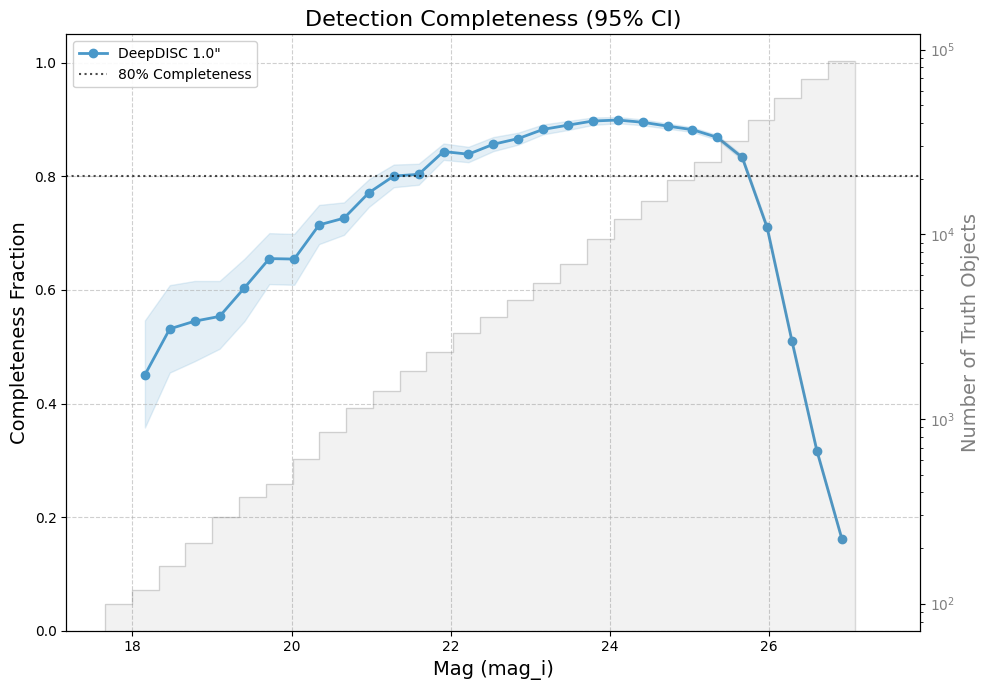

In [152]:
plot_det_comp(
    main_data=dd_stats1, 
    full_truth_cat=lsst_truth_cat,
    main_label='DeepDISC 1.0"'
)

<Axes: title={'center': 'All Objects: Completeness by Matching Radius (95% CI)'}, xlabel='Mag (mag_i)', ylabel='Completeness Fraction'>

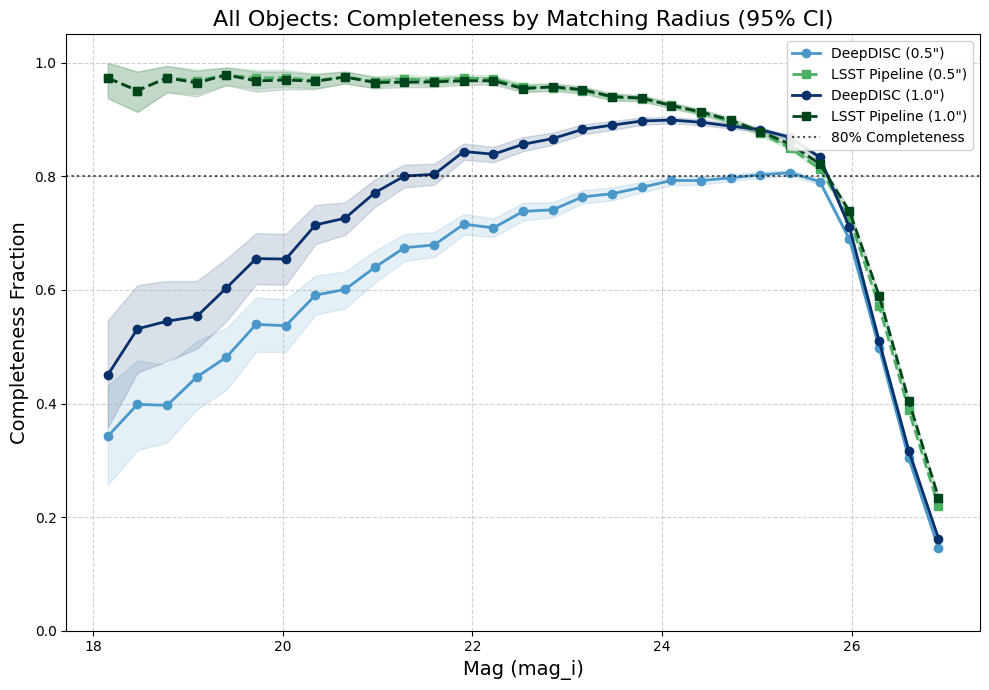

In [156]:
dd_sep_all = {
    '0.5"': dd_stats05, 
    '1.0"': dd_stats1
}
lsst_sep_all = {
    '0.5"': lsst_stats05, 
    '1.0"': lsst_stats1
}
plot_det_comp(
    main_data=dd_sep_all,
    comp_data=lsst_sep_all,
    full_truth_cat=lsst_truth_cat,
    main_label='DeepDISC',
    comp_label='LSST Pipeline',
    title='All Objects: Completeness by Matching Radius',
    show_hist=False, # gotta disable hist since keys (0.5", 1.0") don't map to truth classes
    legend_loc='upper right'
)

In [175]:
print("DeepDISC Comp By Mag Bins")
print_comp_summary(dd_sep_all)
print("LSST Comp By Mag Bins")
print_comp_summary(lsst_sep_all)

DeepDISC Comp By Mag Bins
----------------------------------------
 COMPLETENESS SUMMARY: 0.5"
----------------------------------------
Mag Range       | Comp (%)   | Error (-/+)         
--------------------------------------------------
18.00-18.31     |  34.23%    | - 8.55% / + 8.95%
18.31-18.63     |  39.86%    | - 8.08% / + 7.73%
18.63-18.94     |  39.68%    | - 6.53% / + 7.15%
18.94-19.25     |  44.66%    | - 5.70% / + 6.33%
19.25-19.56     |  48.17%    | - 5.71% / + 5.12%
19.56-19.88     |  53.94%    | - 4.86% / + 4.73%
19.88-20.19     |  53.70%    | - 4.59% / + 4.64%
20.19-20.50     |  59.09%    | - 3.46% / + 3.43%
20.50-20.81     |  60.09%    | - 3.33% / + 3.15%
20.81-21.13     |  63.97%    | - 2.72% / + 2.90%
21.13-21.44     |  67.44%    | - 2.37% / + 2.39%
21.44-21.75     |  67.91%    | - 2.14% / + 2.27%
21.75-22.07     |  71.58%    | - 1.86% / + 1.81%
22.07-22.38     |  70.93%    | - 1.61% / + 1.64%
22.38-22.69     |  73.83%    | - 1.61% / + 1.51%
22.69-23.00     |  74.11% 

<Axes: title={'center': 'Galaxies: Completeness by Matching Radius (95% CI)'}, xlabel='Mag (mag_i)', ylabel='Completeness Fraction'>

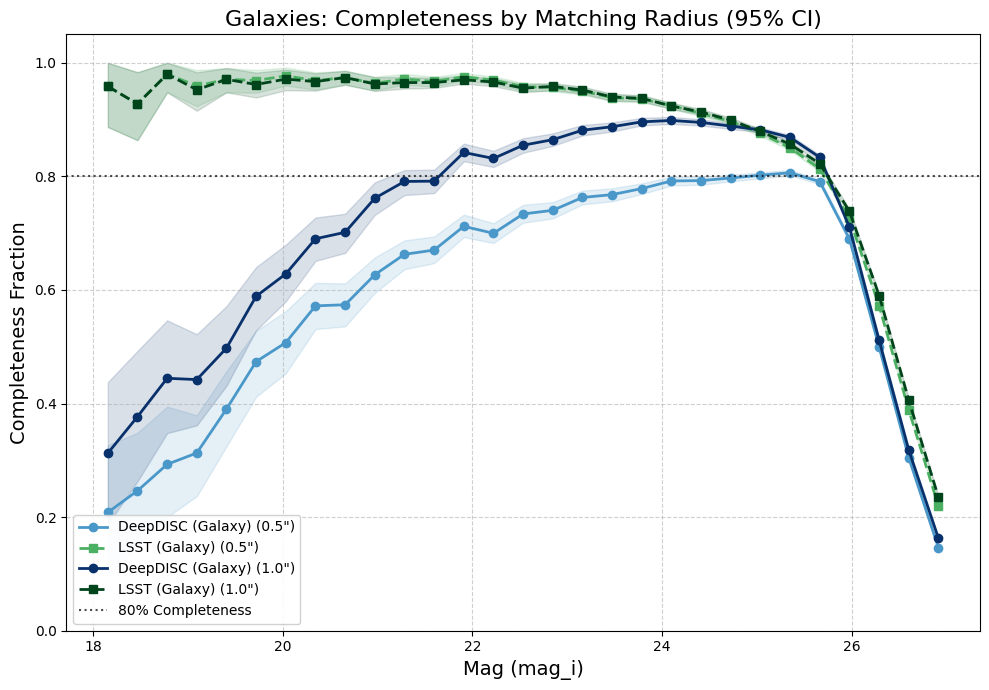

In [159]:
dd_sep_gal = {
    '0.5"': dd_class_stats05['Galaxy'], 
    '1.0"': dd_class_stats1['Galaxy']
}
lsst_sep_gal = {
    '0.5"': lsst_class_stats05['Galaxy'], 
    '1.0"': lsst_class_stats1['Galaxy']
}
plot_det_comp(
    main_data=dd_sep_gal,
    comp_data=lsst_sep_gal,
    full_truth_cat=lsst_truth_cat[lsst_truth_cat['truth_type']==1],
    main_label='DeepDISC (Galaxy)',
    comp_label='LSST (Galaxy)',
    title='Galaxies: Completeness by Matching Radius',
    show_hist=False,
    legend_loc='lower left'
)

In [176]:
print("DeepDISC Comp By Mag Bins")
print_comp_summary(dd_sep_gal)
print("LSST Comp By Mag Bins")
print_comp_summary(lsst_sep_gal)

DeepDISC Comp By Mag Bins
----------------------------------------
 COMPLETENESS SUMMARY: 0.5"
----------------------------------------
Mag Range       | Comp (%)   | Error (-/+)         
--------------------------------------------------
18.00-18.31     |  20.83%    | -11.04% / +11.82%
18.31-18.63     |  24.64%    | - 9.78% / +10.21%
18.63-18.94     |  29.29%    | - 9.30% / +10.16%
18.94-19.25     |  31.29%    | - 7.59% / + 6.64%
19.25-19.56     |  39.02%    | - 6.56% / + 6.68%
19.56-19.88     |  47.39%    | - 6.19% / + 5.43%
19.88-20.19     |  50.72%    | - 5.40% / + 5.55%
20.19-20.50     |  57.20%    | - 4.09% / + 4.05%
20.50-20.81     |  57.39%    | - 3.81% / + 3.76%
20.81-21.13     |  62.67%    | - 3.20% / + 3.04%
21.13-21.44     |  66.27%    | - 2.61% / + 2.46%
21.44-21.75     |  67.02%    | - 2.31% / + 2.39%
21.75-22.07     |  71.20%    | - 1.90% / + 2.05%
22.07-22.38     |  69.97%    | - 1.71% / + 1.78%
22.38-22.69     |  73.37%    | - 1.53% / + 1.61%
22.69-23.00     |  74.02% 

<Axes: title={'center': 'Stars: Completeness by Matching Radius (95% CI)'}, xlabel='Mag (mag_i)', ylabel='Completeness Fraction'>

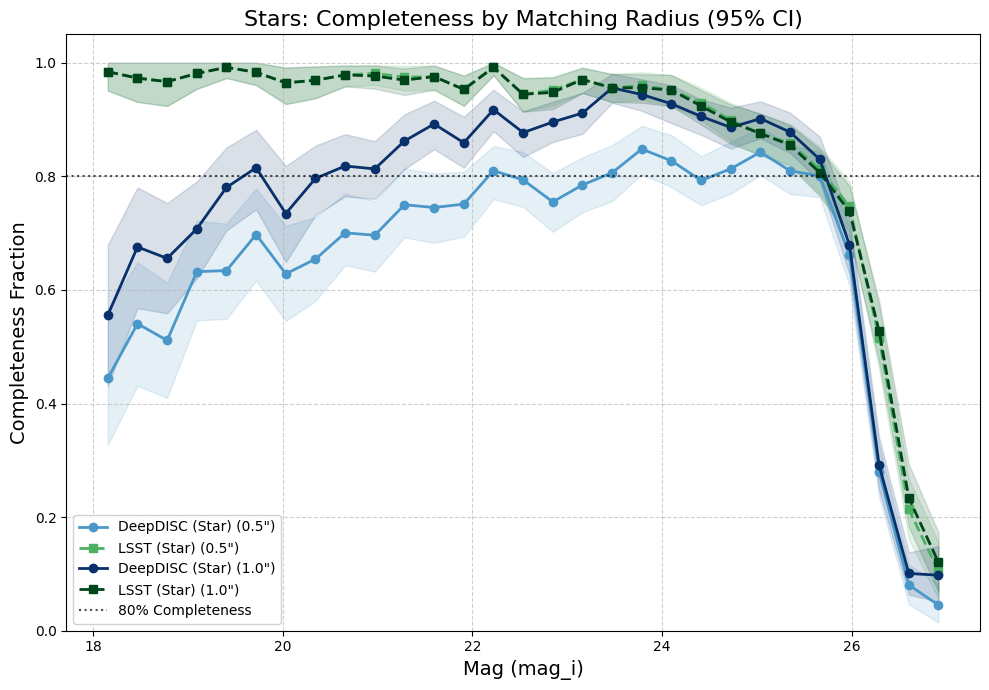

In [162]:
dd_sep_star = {
    '0.5"': dd_class_stats05['Star'], 
    '1.0"': dd_class_stats1['Star']
}
lsst_sep_star = {
    '0.5"': lsst_class_stats05['Star'], 
    '1.0"': lsst_class_stats1['Star']
}
plot_det_comp(
    main_data=dd_sep_star,
    comp_data=lsst_sep_star,
    full_truth_cat=lsst_truth_cat[lsst_truth_cat['truth_type']==2],
    main_label='DeepDISC (Star)',
    comp_label='LSST (Star)',
    title='Stars: Completeness by Matching Radius',
    show_hist=False,
    legend_loc='lower left'
)

In [177]:
print("DeepDISC Comp By Mag Bins")
print_comp_summary(dd_sep_star)
print("LSST Comp By Mag Bins")
print_comp_summary(lsst_sep_star)

DeepDISC Comp By Mag Bins
----------------------------------------
 COMPLETENESS SUMMARY: 0.5"
----------------------------------------
Mag Range       | Comp (%)   | Error (-/+)         
--------------------------------------------------
18.00-18.31     |  44.44%    | -11.67% / +12.23%
18.31-18.63     |  54.05%    | -10.92% / +10.81%
18.63-18.94     |  51.11%    | -10.09% / +10.15%
18.94-19.25     |  63.21%    | - 8.58% / + 8.96%
19.25-19.56     |  63.41%    | - 8.50% / + 8.25%
19.56-19.88     |  69.75%    | - 8.09% / + 8.11%
19.88-20.19     |  62.83%    | - 8.29% / + 8.46%
20.19-20.50     |  65.43%    | - 7.37% / + 7.35%
20.50-20.81     |  70.05%    | - 5.70% / + 6.91%
20.81-21.13     |  69.63%    | - 6.40% / + 5.99%
21.13-21.44     |  75.00%    | - 5.77% / + 6.37%
21.44-21.75     |  74.51%    | - 6.22% / + 6.01%
21.75-22.07     |  75.12%    | - 5.74% / + 5.67%
22.07-22.38     |  80.99%    | - 4.99% / + 4.33%
22.38-22.69     |  79.37%    | - 4.76% / + 4.91%
22.69-23.00     |  75.50% 

<Axes: title={'center': 'Completeness by Class (0.5" Match) (95% CI)'}, xlabel='Mag (mag_i)', ylabel='Completeness Fraction'>

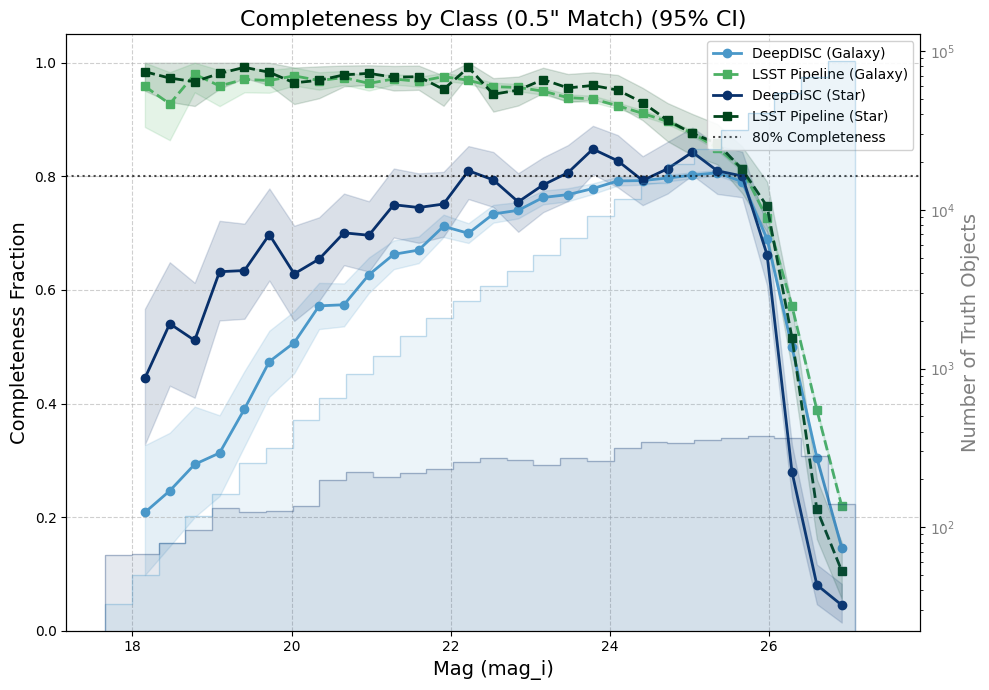

In [168]:
plot_det_comp(
    main_data=dd_class_stats05,
    comp_data=lsst_class_stats05,
    full_truth_cat=lsst_truth_cat,
    main_label='DeepDISC',
    comp_label='LSST Pipeline',
    title='Completeness by Class (0.5" Match)',
    show_hist=True, # true now bc galaxy and star actually map back to classes
    legend_loc='upper right'
)

In [178]:
print("DeepDISC Comp By Mag Bins")
print_comp_summary(dd_class_stats05)
print("LSST Comp By Mag Bins")
print_comp_summary(lsst_class_stats05)

DeepDISC Comp By Mag Bins
----------------------------------------
 COMPLETENESS SUMMARY: GALAXY
----------------------------------------
Mag Range       | Comp (%)   | Error (-/+)         
--------------------------------------------------
18.00-18.31     |  20.83%    | -11.04% / +11.82%
18.31-18.63     |  24.64%    | - 9.78% / +10.21%
18.63-18.94     |  29.29%    | - 9.30% / +10.16%
18.94-19.25     |  31.29%    | - 7.59% / + 6.64%
19.25-19.56     |  39.02%    | - 6.56% / + 6.68%
19.56-19.88     |  47.39%    | - 6.19% / + 5.43%
19.88-20.19     |  50.72%    | - 5.40% / + 5.55%
20.19-20.50     |  57.20%    | - 4.09% / + 4.05%
20.50-20.81     |  57.39%    | - 3.81% / + 3.76%
20.81-21.13     |  62.67%    | - 3.20% / + 3.04%
21.13-21.44     |  66.27%    | - 2.61% / + 2.46%
21.44-21.75     |  67.02%    | - 2.31% / + 2.39%
21.75-22.07     |  71.20%    | - 1.90% / + 2.05%
22.07-22.38     |  69.97%    | - 1.71% / + 1.78%
22.38-22.69     |  73.37%    | - 1.53% / + 1.61%
22.69-23.00     |  74.02

<Axes: title={'center': 'Completeness by Class (1.0" Match) (95% CI)'}, xlabel='Mag (mag_i)', ylabel='Completeness Fraction'>

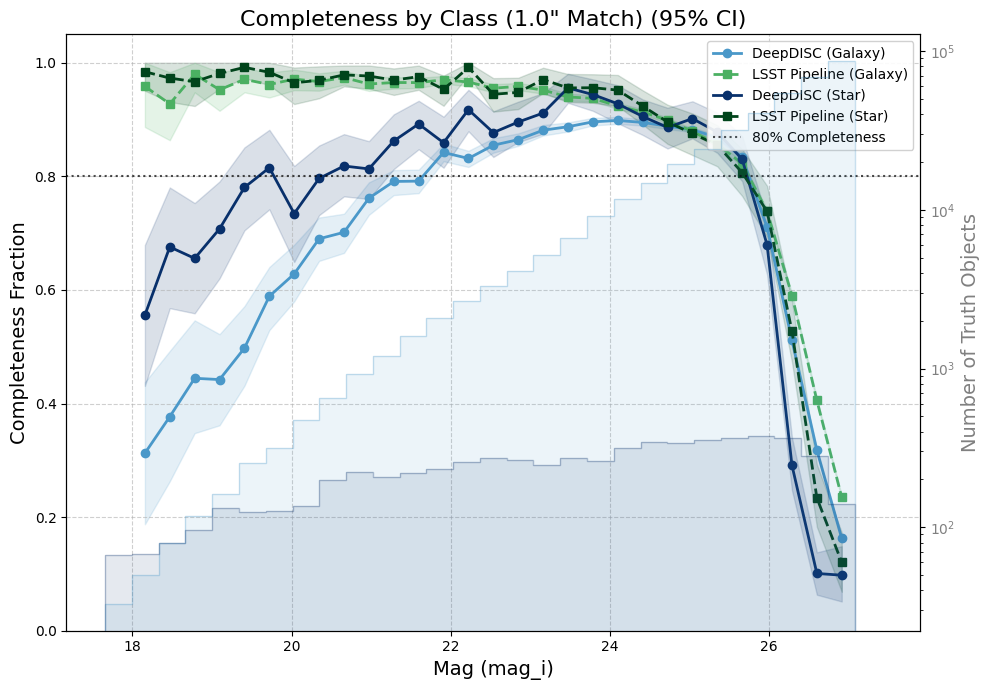

In [169]:
plot_det_comp(
    main_data=dd_class_stats1,
    comp_data=lsst_class_stats1,
    full_truth_cat=lsst_truth_cat,
    main_label='DeepDISC',
    comp_label='LSST Pipeline',
    title='Completeness by Class (1.0" Match)',
    show_hist=True, # true now bc galaxy and star actually map back to classes
    legend_loc='upper right'
)

In [179]:
print("DeepDISC Comp By Mag Bins")
print_comp_summary(dd_class_stats1)
print("LSST Comp By Mag Bins")
print_comp_summary(lsst_class_stats1)

DeepDISC Comp By Mag Bins
----------------------------------------
 COMPLETENESS SUMMARY: GALAXY
----------------------------------------
Mag Range       | Comp (%)   | Error (-/+)         
--------------------------------------------------
18.00-18.31     |  31.25%    | -12.50% / +12.51%
18.31-18.63     |  37.68%    | -11.37% / +11.57%
18.63-18.94     |  44.44%    | - 9.66% / +10.20%
18.94-19.25     |  44.22%    | - 8.05% / + 7.99%
19.25-19.56     |  49.76%    | - 6.63% / + 7.39%
19.56-19.88     |  58.89%    | - 5.97% / + 5.14%
19.88-20.19     |  62.82%    | - 4.84% / + 5.14%
20.19-20.50     |  69.00%    | - 3.89% / + 3.74%
20.50-20.81     |  70.14%    | - 3.63% / + 3.27%
20.81-21.13     |  76.15%    | - 2.93% / + 2.79%
21.13-21.44     |  79.10%    | - 2.40% / + 2.00%
21.44-21.75     |  79.16%    | - 2.12% / + 2.02%
21.75-22.07     |  84.20%    | - 1.54% / + 1.56%
22.07-22.38     |  83.15%    | - 1.51% / + 1.34%
22.38-22.69     |  85.48%    | - 1.31% / + 1.24%
22.69-23.00     |  86.46

# Unrecognized Blend Fraction

Ideally, we want to use the results from the FOF plots here to prevent unnecessary recalculations, but for now, I'm going to be following the two-stage process similar to what I did for replicating the DP1 technote using DeepDISC.

To compare DeepDISC and the LSST Pipeline, we apply similar spatial matching logic used in the technote, but we will swap the `Space/HST` catalog for the LSST Ground Truth catalog since we actually have ground truth.

1) **Symmetric Neighbor Counting (Stage A)**:
For every detection in the catalog (DeepDISC or Pipeline), we calculate two numbers using a 2.0\" search radius. 
- N_det: How many detected objects are in this radius (including itself)? 
- N_truth: How many filtered ground truth objects are in this radius?
2) **Classifying Blends**:
Classify each detection based on counts:
- Unrecognized Blend: N_truth > N_det (More truth objects than detections)
- Recognized Blend/Pure: N_truth <= N_det
- Spurious: N_truth == 0 (Usually excluded from the blend fraction denominator)"
3) **Magnitude Difference Cut**:
This cut prevents a bright object (mag 20) from being classified a 'blend' just because a faint object (mag 26) is nearby ($N_{truth} > N_{det}). Without the cut, we'd get an artificially high blend fraction, since a lot of deep sky fields are crowded with faint objects that don't actually meaningfully impact the photometry of brighter sources. So, we restrict the definition of a blend to only include truth neighbors that are within a specific brightness range (e.g., 2.0 mags) of the main object. This filters out negligible background objects and focuses the metric on *significant* blends (cases where overlapping sources have comparable fluxes that would actually affect downstream tasks)

In [15]:
# load in the pred file with mags
dd_det_cat = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/pred_with_mag_s0.45_n0.3.json', orient='records')

In [16]:
print(f"DeepDISC objects (incl. NAN mag_i's): {len(dd_det_cat)}")
print(f"LSST Pipeline objects (incl. NAN mag_i's): {len(lsst_det_cat)}")
print(f"Truth objects (incl. NAN mag_i's but after depth/mag cut): {len(lsst_truth_cat)}")
# drop NaNs in mag cols to avoid errors during binning/matching
dd_det_cat = dd_det_cat.dropna(subset=['mag_i']).reset_index(drop=True)
lsst_det_cat = lsst_det_cat.dropna(subset=['mag_i_cModel']).reset_index(drop=True)
lsst_truth_cat = lsst_truth_cat.dropna(subset=['mag_i']).reset_index(drop=True)
print(f"DeepDISC objects: {len(dd_det_cat)}")
print(f"LSST Pipeline objects: {len(lsst_det_cat)}")
print(f"Truth objects (after depth/mag cut): {len(lsst_truth_cat)}")

DeepDISC objects (incl. NAN mag_i's): 237881
LSST Pipeline objects (incl. NAN mag_i's): 271146
Truth objects (incl. NAN mag_i's but after depth/mag cut): 470000
DeepDISC objects: 237654
LSST Pipeline objects: 270034
Truth objects (after depth/mag cut): 470000


In [7]:
# for mag 27.3
print(f"DeepDISC objects (incl. NAN mag_i's): {len(dd_det_cat)}")
print(f"LSST Pipeline objects (incl. NAN mag_i's): {len(lsst_det_cat)}")
print(f"Truth objects (incl. NAN mag_i's but after depth/mag cut): {len(lsst_truth_cat)}")
# drop NaNs in mag cols to avoid errors during binning/matching
dd_det_cat = dd_det_cat.dropna(subset=['mag_i']).reset_index(drop=True)
lsst_det_cat = lsst_det_cat.dropna(subset=['mag_i_cModel']).reset_index(drop=True)
lsst_truth_cat = lsst_truth_cat.dropna(subset=['mag_i']).reset_index(drop=True)
print(f"DeepDISC objects: {len(dd_det_cat)}")
print(f"LSST Pipeline objects: {len(lsst_det_cat)}")
print(f"Truth objects (after depth/mag cut): {len(lsst_truth_cat)}")

DeepDISC objects (incl. NAN mag_i's): 237881
LSST Pipeline objects (incl. NAN mag_i's): 271146
Truth objects (incl. NAN mag_i's but after depth/mag cut): 254725
DeepDISC objects: 237654
LSST Pipeline objects: 270034
Truth objects (after depth/mag cut): 254725


In [17]:
# standardize cols
dd_det_cat['chosen_mag'] = dd_det_cat['mag_i']
lsst_det_cat['chosen_mag'] = lsst_det_cat['mag_i_cModel']
lsst_truth_cat['chosen_mag'] = lsst_truth_cat['mag_i']

In [14]:
# dd_det_cat
# lsst_det_cat
lsst_truth_cat

,ra,dec,mag_i,class,obj_id,obj_truth_idx,chosen_mag
0,53.663637,-41.215570,26.462698,0,9502312400,8,26.462698
1,53.666375,-41.218364,26.182444,0,9501803150,9,26.182444
2,53.666449,-41.216024,23.855207,0,9502520267,13,23.855207
3,53.666394,-41.215661,24.306143,0,9502520268,14,24.306143
4,53.668981,-41.222707,25.905224,0,9502137039,18,25.905224
...,...,...,...,...,...,...,...
254720,51.393470,-39.274480,26.819012,0,8641057299,129,26.819012
254721,51.388997,-39.281391,25.149429,0,8641061146,130,25.149429
254722,51.387510,-39.279938,26.572065,0,8641062913,131,26.572065
254723,51.388541,-39.281171,25.909340,0,8641062914,132,25.909340


In [18]:
def analyze_unrec_blends(det_cat, truth_cat, 
                                search_radius=2.0, 
                                use_m_delta=False, 
                                m_delta=2.0):
    """
    Calculates N_det and N_truth for every detection to identify unrecognized blends
    Parameters:
        det_cat (pd.DataFrame): Det catalog (must have 'ra', 'dec', 'chosen_mag')
        truth_cat (pd.DataFrame): Truth catalog (must have 'ra', 'dec', 'chosen_mag')
        search_radius (float): Search radius in arcseconds (default 2.0)
        use_m_delta (bool): If True, applies mag difference logic
        m_delta (float): The mag window for counting truth neighbors
        
    Returns:
        dict: Contains boolean masks and count arrays.
    """
    c_det = SkyCoord(ra=det_cat['ra'].values*u.deg, dec=det_cat['dec'].values*u.deg)
    c_truth = SkyCoord(ra=truth_cat['ra'].values*u.deg, dec=truth_cat['dec'].values*u.deg)
    # --- Stage A: N_det (Ground-Ground equivalent from technote) ---
    # count how many dets are within radius of itself
    # search_around_sky includes the object itself if radius > 0
    idx_d1, idx_d2, _, _ = search_around_sky(c_det, c_det, seplimit=search_radius*u.arcsec)
    N_det = np.bincount(idx_d1, minlength=len(det_cat))
    # --- Stage B: N_truth (Ground-Truth equivalent from technote) ---
    idx_det_match, idx_truth_match, _, _ = search_around_sky(c_det, c_truth, seplimit=search_radius*u.arcsec)
    # --- Stage C: Filter N_truth by m_delta if flag true ---
    if not use_m_delta:
        # simple count of all truth objs within radius
        # THIS MIGHT NOT BE FULLY ACCURATE and GIVE ARTIFICALLY BOOSTED UBF
        N_truth_final = np.bincount(idx_det_match, minlength=len(det_cat))
    else:
        # Ok, for this filter, we need to count only truth objs that are "significant"
        # i.e., within m_delta of the brightest truth neighbor for that detection
        # let's make a tmp df of matches to use pandas groupby
        match_df = pd.DataFrame({
            'det_idx': idx_det_match,
            'truth_mag': truth_cat['chosen_mag'].values[idx_truth_match]
        })
        # mag of brightest truth neighbor for each detection
        brightest_mag = match_df.groupby('det_idx')['truth_mag'].min()
        # map brightest mag back to the match list
        match_df['brightest_mag'] = match_df['det_idx'].map(brightest_mag)
        # now we filter matches: keep only those within window that we set
        # (truth_mag <= brightest + m_delta)
        valid_matches = match_df[match_df['truth_mag'] <= (match_df['brightest_mag'] + m_delta)]
        # valid matches
        N_truth_final = np.bincount(valid_matches['det_idx'], minlength=len(det_cat))

    # --- Classification ---
    # unrec blend: Truth matches > Detected matches (multiple sources were detected as one)
    is_unrec = N_truth_final > N_det
    # spurious/split: Detected matches > Truth matches (usually excluded from denom using its mask)
    is_spurious = N_det > N_truth_final
    # Eligible: Denom for the fraction
    # Technote defines eligibility as objects that are NOT spurious
    # i.e., N_truth >= N_det. We also want at least one truth match to even talk about blending properly
    has_match = N_truth_final > 0
    eligible_mask = (~is_spurious) & has_match
    return {
        'is_unrec': is_unrec,
        'eligible_mask': eligible_mask,
        'N_det': N_det,
        'N_truth': N_truth_final
    }

In [12]:
RADIUS = 2.0 # arcsec
ENABLE_M_DELTA = False
M_DELTA = 2.0
print(f"Running matching (Radius={RADIUS}", f"m_delta={ENABLE_M_DELTA})...")
# for DeepDISC
print("Processing DeepDISC...")
dd_results = analyze_unrec_blends(dd_det_cat, lsst_truth_cat, 
                                         search_radius=RADIUS, 
                                         use_m_delta=ENABLE_M_DELTA, 
                                         m_delta=M_DELTA)
# for LSST Pipeline
print("Processing LSST Pipeline...")
lsst_results = analyze_unrec_blends(lsst_det_cat, lsst_truth_cat, 
                                           search_radius=RADIUS, 
                                           use_m_delta=ENABLE_M_DELTA, 
                                           m_delta=M_DELTA)

Running matching (Radius=2.0 m_delta=False)...
Processing DeepDISC...
Processing LSST Pipeline...


In [13]:
dd_results, lsst_results

({'is_unrec': array([False,  True, False, ..., False, False, False], shape=(237654,)),
  'eligible_mask': array([ True,  True,  True, ...,  True, False, False], shape=(237654,)),
  'N_det': array([1, 1, 1, ..., 2, 2, 1], shape=(237654,)),
  'N_truth': array([1, 2, 1, ..., 2, 1, 0], shape=(237654,))},
 {'is_unrec': array([False, False, False, ..., False, False, False], shape=(270034,)),
  'eligible_mask': array([ True, False,  True, ..., False, False, False], shape=(270034,)),
  'N_det': array([1, 1, 1, ..., 3, 3, 1], shape=(270034,)),
  'N_truth': array([1, 0, 1, ..., 1, 1, 0], shape=(270034,))})

In [19]:
def calc_fracs(det_cat, results, bins):
    mags = det_cat['chosen_mag'].values
    is_unrec = results['is_unrec']
    eligible = results['eligible_mask']
    centers = []
    fractions = []
    errors = []
    for i in range(len(bins)-1):
        low, high = bins[i], bins[i+1]
        # mask for this bin AND eligibility
        bin_mask = (mags >= low) & (mags < high) & eligible
        n_denom = np.sum(bin_mask)
        if n_denom > 10: # min count to plot
            n_num = np.sum(bin_mask & is_unrec)
            frac = n_num / n_denom
            # just using binomial error bars
            # TODO: Use boostrapping to get error bars instead
            err = np.sqrt(frac * (1 - frac) / n_denom)
            centers.append((low + high) / 2)
            fractions.append(frac)
            errors.append(err)
        else:
            centers.append((low + high) / 2)
            fractions.append(np.nan)
            errors.append(np.nan)
    # let's just do overall as well
    total_eligible = np.sum(eligible)
    total_unrec = np.sum(is_unrec & eligible)
    overall_frac = total_unrec / total_eligible if total_eligible > 0 else 0.0
    return np.array(centers), np.array(fractions), np.array(errors), overall_frac

--- Summary Stats ---
DeepDISC: 13.74%  (24451 / 177918)
LSST Pipeline: 12.71%  (22632 / 178034)
DeepDISC Overall Eligible: 177918
DeepDISC Overall Unrec Blends: 24451
LSST Pipeline Overall Eligible: 178034
LSST Pipeline Overall Unrec Blends: 22632

--- Fractions per Magnitude Bin ---
Mag Center   | DeepDISC Frac   | LSST Pipe Frac 
------------------------------------------------
16.25        | 0.1944          | 0.1781         
16.75        | 0.2059          | 0.2551         
17.25        | 0.2840          | 0.2519         
17.75        | 0.2190          | 0.2812         
18.25        | 0.2083          | 0.3000         
18.75        | 0.2217          | 0.3265         
19.25        | 0.2006          | 0.2994         
19.75        | 0.1966          | 0.2663         
20.25        | 0.2160          | 0.2998         
20.75        | 0.2336          | 0.2915         
21.25        | 0.2528          | 0.3178         
21.75        | 0.2561          | 0.3130         
22.25        | 0.2685       

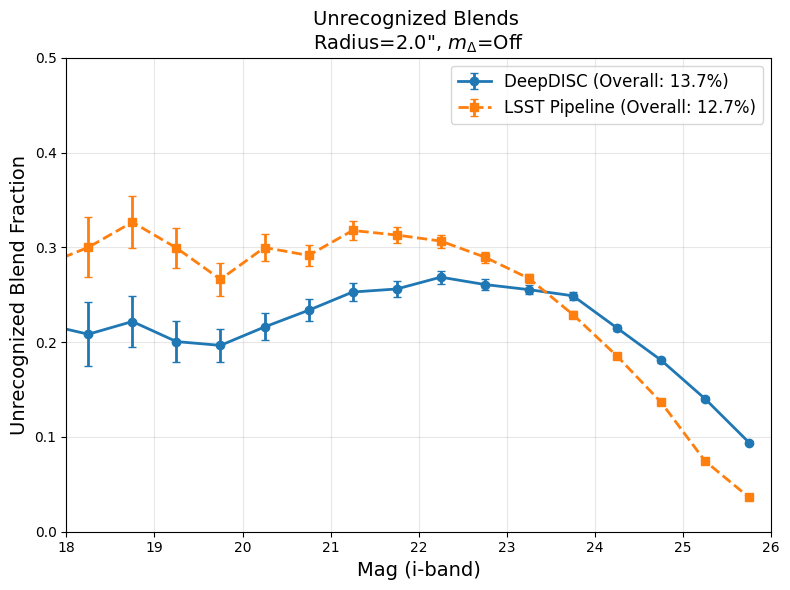

In [15]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)
dd_x, dd_y, dd_err, dd_overall = calc_fracs(dd_det_cat, dd_results, mag_bins)
lsst_x, lsst_y, lsst_err, lsst_overall = calc_fracs(lsst_det_cat, lsst_results, mag_bins)
plt.figure(figsize=(8, 6))
# DeepDISC
plt.errorbar(dd_x, dd_y, yerr=dd_err, fmt='o-', capsize=3, 
             label=f'DeepDISC (Overall: {dd_overall:.1%})', color='tab:blue', linewidth=2)
# LSST Pipeline
plt.errorbar(lsst_x, lsst_y, yerr=lsst_err, fmt='s--', capsize=3, 
             label=f'LSST Pipeline (Overall: {lsst_overall:.1%})', color='tab:orange', linewidth=2)

plt.xlabel('Mag (i-band)', fontsize=14)
plt.ylabel('Unrecognized Blend Fraction', fontsize=14)
plt.title(f'Unrecognized Blends \nRadius={RADIUS}", $m_{{\\Delta}}$={M_DELTA if ENABLE_M_DELTA else "Off"}', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.5)
plt.xlim(18, 26)
plt.tight_layout()
print("--- Summary Stats ---")
print(f"DeepDISC: {dd_overall:.2%}  ({np.sum(dd_results['is_unrec'] & dd_results['eligible_mask'])} / {np.sum(dd_results['eligible_mask'])})")
print(f"LSST Pipeline: {lsst_overall:.2%}  ({np.sum(lsst_results['is_unrec'] & lsst_results['eligible_mask'])} / {np.sum(lsst_results['eligible_mask'])})")
print(f"DeepDISC Overall Eligible: {np.sum(dd_results['eligible_mask'])}")
print(f"DeepDISC Overall Unrec Blends: {np.sum(dd_results['is_unrec'])}")
print(f"LSST Pipeline Overall Eligible: {np.sum(lsst_results['eligible_mask'])}")
print(f"LSST Pipeline Overall Unrec Blends: {np.sum(lsst_results['is_unrec'])}")
print("\n--- Fractions per Magnitude Bin ---")
# fancy way of formatting the strings to left-align the text within a field that is x characters wide
# < is left alignment and num is minimum field width
print(f"{'{:<12}'.format('Mag Center')} | {'{:<15}'.format('DeepDISC Frac')} | {'{:<15}'.format('LSST Pipe Frac')}")
print("-" * 48)
for mag, dd_frac, lsst_frac in zip(dd_x, dd_y, lsst_y):
    # Format fractions, handling NaNs (bins with insufficient data)
    dd_str = f"{dd_frac:.4f}" if not np.isnan(dd_frac) else "   --   "
    lsst_str = f"{lsst_frac:.4f}" if not np.isnan(lsst_frac) else "   --   "
    print(f"{mag:<12.2f} | {dd_str:<15} | {lsst_str:<15}")

In [16]:
RADIUS = 2.0 # arcsec
ENABLE_M_DELTA = True
M_DELTA = 2.0
print(f"Running matching (Radius={RADIUS}", f"m_delta={ENABLE_M_DELTA})...")
# for DeepDISC
print("Processing DeepDISC...")
dd_results = analyze_unrec_blends(dd_det_cat, lsst_truth_cat, 
                                         search_radius=RADIUS, 
                                         use_m_delta=ENABLE_M_DELTA, 
                                         m_delta=M_DELTA)
# for LSST Pipeline
print("Processing LSST Pipeline...")
lsst_results = analyze_unrec_blends(lsst_det_cat, lsst_truth_cat, 
                                           search_radius=RADIUS, 
                                           use_m_delta=ENABLE_M_DELTA, 
                                           m_delta=M_DELTA)

Running matching (Radius=2.0 m_delta=True)...
Processing DeepDISC...
Processing LSST Pipeline...


--- Summary Stats ---
DeepDISC: 10.70%  (18315 / 171204)
LSST Pipeline: 8.68%  (15205 / 175108)
DeepDISC Overall Eligible: 171204
DeepDISC Overall Unrec Blends: 18315
LSST Pipeline Overall Eligible: 175108
LSST Pipeline Overall Unrec Blends: 15205

--- Fractions per Magnitude Bin ---
Mag Center   | DeepDISC Frac   | LSST Pipe Frac 
------------------------------------------------
16.25        | 0.0000          | 0.0000         
16.75        | 0.0154          | 0.0102         
17.25        | 0.0000          | 0.0000         
17.75        | 0.0000          | 0.0000         
18.25        | 0.0078          | 0.0000         
18.75        | 0.0400          | 0.0068         
19.25        | 0.0261          | 0.0172         
19.75        | 0.0352          | 0.0250         
20.25        | 0.0572          | 0.0287         
20.75        | 0.0467          | 0.0377         
21.25        | 0.0653          | 0.0599         
21.75        | 0.0801          | 0.0637         
22.25        | 0.1116        

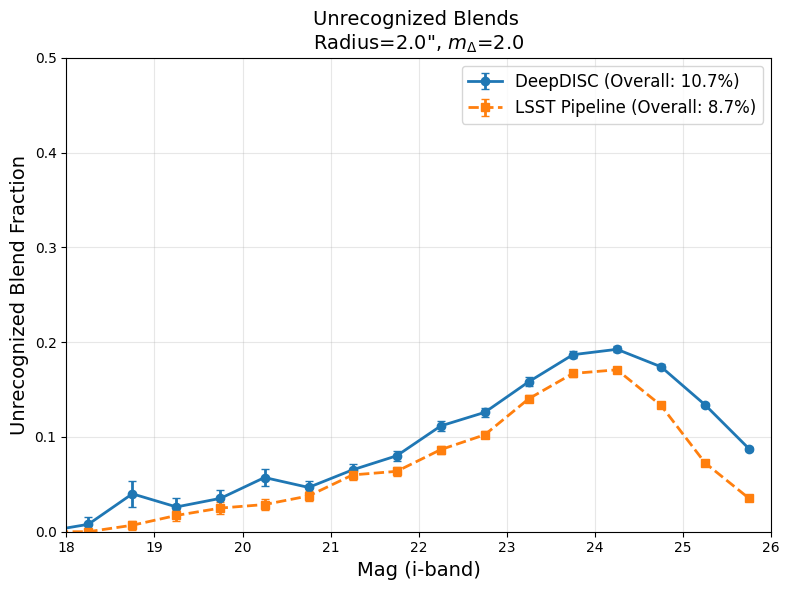

In [17]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)
dd_x, dd_y, dd_err, dd_overall = calc_fracs(dd_det_cat, dd_results, mag_bins)
lsst_x, lsst_y, lsst_err, lsst_overall = calc_fracs(lsst_det_cat, lsst_results, mag_bins)
plt.figure(figsize=(8, 6))
# DeepDISC
plt.errorbar(dd_x, dd_y, yerr=dd_err, fmt='o-', capsize=3, 
             label=f'DeepDISC (Overall: {dd_overall:.1%})', color='tab:blue', linewidth=2)
# LSST Pipeline
plt.errorbar(lsst_x, lsst_y, yerr=lsst_err, fmt='s--', capsize=3, 
             label=f'LSST Pipeline (Overall: {lsst_overall:.1%})', color='tab:orange', linewidth=2)

plt.xlabel('Mag (i-band)', fontsize=14)
plt.ylabel('Unrecognized Blend Fraction', fontsize=14)
plt.title(f'Unrecognized Blends \nRadius={RADIUS}", $m_{{\\Delta}}$={M_DELTA if ENABLE_M_DELTA else "Off"}', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.5)
plt.xlim(18, 26)
plt.tight_layout()
print("--- Summary Stats ---")
print(f"DeepDISC: {dd_overall:.2%}  ({np.sum(dd_results['is_unrec'] & dd_results['eligible_mask'])} / {np.sum(dd_results['eligible_mask'])})")
print(f"LSST Pipeline: {lsst_overall:.2%}  ({np.sum(lsst_results['is_unrec'] & lsst_results['eligible_mask'])} / {np.sum(lsst_results['eligible_mask'])})")
print(f"DeepDISC Overall Eligible: {np.sum(dd_results['eligible_mask'])}")
print(f"DeepDISC Overall Unrec Blends: {np.sum(dd_results['is_unrec'])}")
print(f"LSST Pipeline Overall Eligible: {np.sum(lsst_results['eligible_mask'])}")
print(f"LSST Pipeline Overall Unrec Blends: {np.sum(lsst_results['is_unrec'])}")
print("\n--- Fractions per Magnitude Bin ---")
# fancy way of formatting the strings to left-align the text within a field that is x characters wide
# < is left alignment and num is minimum field width
print(f"{'{:<12}'.format('Mag Center')} | {'{:<15}'.format('DeepDISC Frac')} | {'{:<15}'.format('LSST Pipe Frac')}")
print("-" * 48)
for mag, dd_frac, lsst_frac in zip(dd_x, dd_y, lsst_y):
    # Format fractions, handling NaNs (bins with insufficient data)
    dd_str = f"{dd_frac:.4f}" if not np.isnan(dd_frac) else "   --   "
    lsst_str = f"{lsst_frac:.4f}" if not np.isnan(lsst_frac) else "   --   "
    print(f"{mag:<12.2f} | {dd_str:<15} | {lsst_str:<15}")

## Comparison Plots with different matching radii and $m_{\Delta}$

In [20]:
mag_bins = np.arange(16, truth_mag_limit, 0.2)

In [26]:
def run_unrec_analysis_grid(dd_cat, lsst_cat, truth_cat, 
                            radius_list, m_delta_list, 
                            mag_bins, use_m_delta=True):
    results = []
    for radius in radius_list:
        for m_delta in m_delta_list:
            print(f"Calculating: R={radius}, m_delta={m_delta}...")
            dd_res = analyze_unrec_blends(dd_cat, truth_cat, radius, use_m_delta, m_delta)
            lsst_res = analyze_unrec_blends(lsst_cat, truth_cat, radius, use_m_delta, m_delta)
            # fractions
            dd_x, dd_y, dd_err, dd_ovr = calc_fracs(dd_cat, dd_res, mag_bins)
            lsst_x, lsst_y, lsst_err, lsst_ovr = calc_fracs(lsst_cat, lsst_res, mag_bins)
            results.append({
                'radius': radius,
                'm_delta': m_delta,
                'dd': {'x': dd_x, 'y': dd_y, 'err': dd_err, 'overall': dd_ovr},
                'lsst': {'x': lsst_x, 'y': lsst_y, 'err': lsst_err, 'overall': lsst_ovr}
            })
            print(f"DeepDISC: {dd_ovr:.2%} ({np.sum(dd_res['is_unrec'] & dd_res['eligible_mask'])} / {np.sum(dd_res['eligible_mask'])})")
            print(f"LSST Pipeline: {lsst_ovr:.2%} ({np.sum(lsst_res['is_unrec'] & lsst_res['eligible_mask'])} / {np.sum(lsst_res['eligible_mask'])})")
            print(f"DeepDISC Overall Unrec Blends: {np.sum(dd_res['is_unrec'])}")
            print(f"DeepDISC Overall Eligible: {np.sum(dd_res['eligible_mask'])}")
            print(f"LSST Pipeline Overall Unrec Blends: {np.sum(lsst_res['is_unrec'])}")
            print(f"LSST Pipeline Overall Eligible: {np.sum(lsst_res['eligible_mask'])}\n")
            print("\n--- Fractions per Magnitude Bin ---")
            # fancy way of formatting the strings to left-align the text within a field that is x characters wide
            # < is left alignment and num is minimum field width
            print(f"{'{:<12}'.format('Mag Center')} | {'{:<15}'.format('DeepDISC Frac')} | {'{:<15}'.format('LSST Pipe Frac')}")
            print("-" * 48)
            for mag, dd_frac, lsst_frac in zip(dd_x, dd_y, lsst_y):
                # Format fractions, handling NaNs (bins with insufficient data)
                dd_str = f"{dd_frac:.4f}" if not np.isnan(dd_frac) else "   --   "
                lsst_str = f"{lsst_frac:.4f}" if not np.isnan(lsst_frac) else "   --   "
                print(f"{mag:<12.2f} | {dd_str:<15} | {lsst_str:<15}")
    return results

def plot_comparison(results, dd_det_cat, lsst_det_cat, mag_bins, 
                    title_suffix=None, use_m_delta=True, show_hist=True,
                    show_dd_hist=True, show_lsst_hist=True):
    """
    Plots unrecognized blend fractions and residuals (DD - LSST) w/ a separate 
    histogram panel on top.
    
    Layout: 
      - Top: Magnitude Histogram (Log Scale)
      - Middle: Blend Fraction Curves
      - Bottom: Residuals (DD - LSST)
    """
    # ok before I tried dotted lines and it gets really messy and hard to understand
    # so let's use color gradients instead and also create a residual plot so we can understand the performance diff
    fig = plt.figure(figsize=(15, 14))
    # ~20%, 60%, 20%
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 3, 1], hspace=0.05)
    ax_hist = plt.subplot(gs[0])
    ax_main = plt.subplot(gs[1], sharex=ax_hist)
    ax_ratio = plt.subplot(gs[2], sharex=ax_hist)

    # Top Histogram Panel
    if show_hist:
        if show_dd_hist and dd_det_cat is not None:
            mags_dd = dd_det_cat['mag_i'].values
            mags_dd = mags_dd[np.isfinite(mags_dd)]
            ax_hist.hist(mags_dd, bins=mag_bins, color='tab:blue', alpha=0.3, 
                         label=f'DeepDISC Catalog ({len(mags_dd)} objs)', histtype='stepfilled', edgecolor='blue')
        if show_lsst_hist and lsst_det_cat is not None:
            mags_lsst = lsst_det_cat['mag_i'].values
            mags_lsst = mags_lsst[np.isfinite(mags_lsst)]
            ax_hist.hist(mags_lsst, bins=mag_bins, color='tab:orange', alpha=0.3, 
                         label=f'LSST Catalog ({len(mags_lsst)} objs)', histtype='stepfilled', edgecolor='orange')
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel('Counts', fontsize=12)
        ax_hist.legend(loc='best', fontsize=10)
        ax_hist.grid(True, alpha=0.3)
    else:
        # no hist means hide axis content but keep structure
        ax_hist.axis('off')
    # hide x-ticks for top and middle plots so it's cleaner
    plt.setp(ax_hist.get_xticklabels(), visible=False)
    plt.setp(ax_main.get_xticklabels(), visible=False)

    # Middle and Bottom
    n_configs = len(results)
    # generate colors form light to dark
    blues = cm.Blues(np.linspace(0.5, 1.0, n_configs))
    oranges = cm.Oranges(np.linspace(0.5, 1.0, n_configs))
    for idx, res in enumerate(results):
        r, md = res['radius'], res['m_delta']
        label_suffix = f"R={r}" + (f", $m_\\Delta$={md}" if use_m_delta else "")
        # DeepDISC
        ax_main.errorbar(res['dd']['x'], res['dd']['y'], yerr=res['dd']['err'],
                         fmt='o-', color=blues[idx], 
                         label=f'DD ({label_suffix}): {res["dd"]["overall"]:.1%}',
                         capsize=3, alpha=0.9, linewidth=1.5)
        # LSST
        ax_main.errorbar(res['lsst']['x'], res['lsst']['y'], yerr=res['lsst']['err'],
                         fmt='s--', color=oranges[idx], 
                         label=f'LSST ({label_suffix}): {res["lsst"]["overall"]:.1%}',
                         capsize=3, alpha=0.9, linewidth=1.5)
        
        # DeepDISC/LSST
        # res_dd_y = res['dd']['y'].copy()
        # res_lsst_y = res['lsst']['y'].copy()
        # # clean NaNs for ratio plot
        # clean_res_mask = (~np.isnan(res['dd']['y'])) & (~np.isnan(res['lsst']['y']))
        # diff = res_dd_y[clean_res_mask]/res_lsst_y[clean_res_mask]
        diff = res['dd']['y'] - res['lsst']['y']
        # propagate err roughly: sqrt(err1^2 + err2^2)
        # TODO: MAKE THIS MORE ROBUST
        diff_err = np.sqrt(res['dd']['err']**2 + res['lsst']['err']**2)
        ax_ratio.errorbar(res['dd']['x'], diff, yerr=diff_err, 
                          fmt='o-', color=blues[idx], alpha=0.7,
                          label=label_suffix, capsize=2) # using DD blue colors to associate it with that config
        ax_ratio.axhline(0, color='k', linestyle=':', linewidth=1)

    ax_main.set_ylabel('Unrecognized Blend Fraction', fontsize=14)
    ax_main.set_ylim(0, 0.5)
    ax_main.grid(True, alpha=0.3)
    ax_main.legend(loc='upper left', fontsize=10, frameon=True)

    ax_ratio.axhline(0, color='k', linestyle=':', linewidth=1)
    ax_ratio.set_ylabel('DD - LSST', fontsize=12)
    ax_ratio.set_xlabel('Mag (i-band)', fontsize=14)
    ax_ratio.grid(True, alpha=0.3)
    ax_ratio.set_ylim(-0.1, 0.1)
    #  = f"R={r}" + (f", $m_\\Delta$={md}" if title_suffix else "")
    plt.suptitle(f'Unrecognized Blends: DeepDISC vs LSST Pipeline {title_suffix if title_suffix else " "}', fontsize=16, y=0.90)

In [22]:
results_rads = run_unrec_analysis_grid(dd_det_cat, lsst_det_cat, lsst_truth_cat,
                            radius_list=[0.5, 1.0, 2.0],
                            m_delta_list=[2.0],
                            mag_bins=mag_bins,
                            use_m_delta=True)

Calculating: R=0.5, m_delta=2.0...


DeepDISC: 5.36% (11328 / 211183)
LSST Pipeline: 5.20% (13053 / 250788)
DeepDISC Overall Unrec Blends: 11328
DeepDISC Overall Eligible: 211183
LSST Pipeline Overall Unrec Blends: 13053
LSST Pipeline Overall Eligible: 250788


--- Fractions per Magnitude Bin ---
Mag Center   | DeepDISC Frac   | LSST Pipe Frac 
------------------------------------------------
16.10        |    --           | 0.0000         
16.30        |    --           | 0.0000         
16.50        | 0.0000          | 0.0000         
16.70        | 0.0000          | 0.0000         
16.90        | 0.0000          | 0.0000         
17.10        | 0.0000          | 0.0000         
17.30        | 0.0000          | 0.0000         
17.50        | 0.0000          | 0.0000         
17.70        | 0.0000          | 0.0000         
17.90        | 0.0000          | 0.0000         
18.10        | 0.0000          | 0.0000         
18.30        | 0.0000          | 0.0000         
18.50        | 0.0000          | 0.0000         
18.7

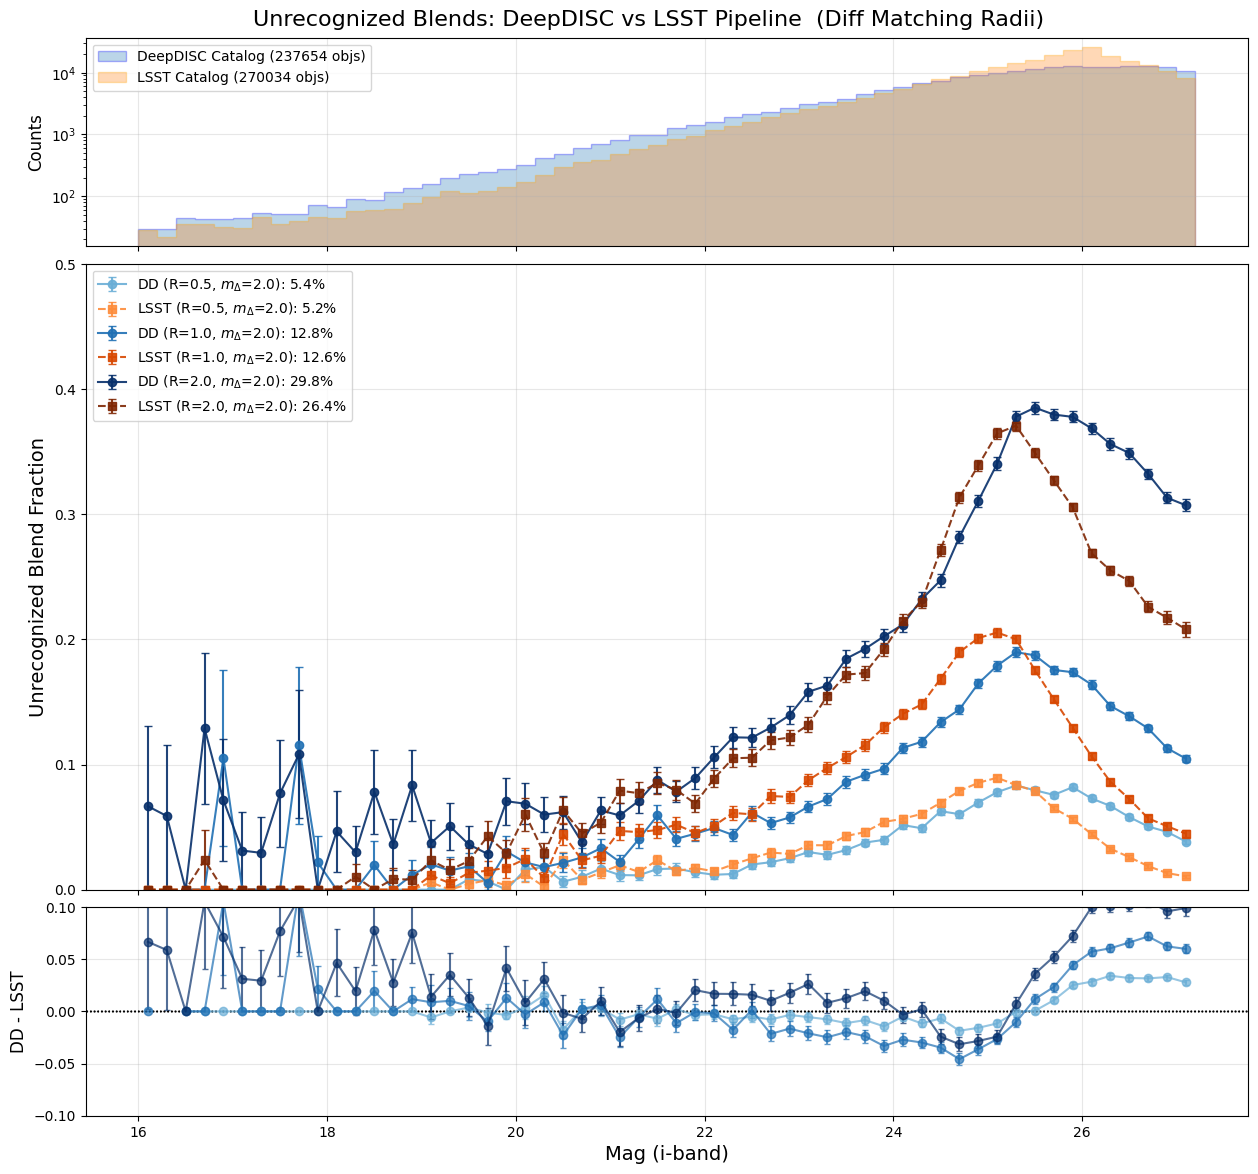

In [27]:
plot_comparison(results_rads, dd_det_cat, lsst_det_cat, mag_bins, title_suffix=' (Diff Matching Radii)')

In [ ]:
results_m_deltas = run_unrec_analysis_grid(dd_det_cat, lsst_det_cat, lsst_truth_cat,
                            radius_list=[2.0],
                            m_delta_list=[1.0, 1.5, 2.0, 2.5],
                            mag_bins=mag_bins,
                            use_m_delta=True)

Calculating: R=2.0, m_delta=1.0...
DeepDISC: 7.01% (11572 / 165006)
LSST Pipeline: 5.27% (8859 / 167981)
DeepDISC Overall Unrec Blends: 11572
DeepDISC Overall Eligible: 165006
LSST Pipeline Overall Unrec Blends: 8859
LSST Pipeline Overall Eligible: 167981

Calculating: R=2.0, m_delta=1.5...
DeepDISC: 9.19% (15495 / 168652)
LSST Pipeline: 7.21% (12424 / 172336)
DeepDISC Overall Unrec Blends: 15495
DeepDISC Overall Eligible: 168652
LSST Pipeline Overall Unrec Blends: 12424
LSST Pipeline Overall Eligible: 172336

Calculating: R=2.0, m_delta=2.0...
DeepDISC: 10.70% (18315 / 171204)
LSST Pipeline: 8.68% (15205 / 175108)
DeepDISC Overall Unrec Blends: 18315
DeepDISC Overall Eligible: 171204
LSST Pipeline Overall Unrec Blends: 15205
LSST Pipeline Overall Eligible: 175108

Calculating: R=2.0, m_delta=2.5...
DeepDISC: 11.69% (20233 / 173054)
LSST Pipeline: 9.83% (17349 / 176543)
DeepDISC Overall Unrec Blends: 20233
DeepDISC Overall Eligible: 173054
LSST Pipeline Overall Unrec Blends: 17349
LSST

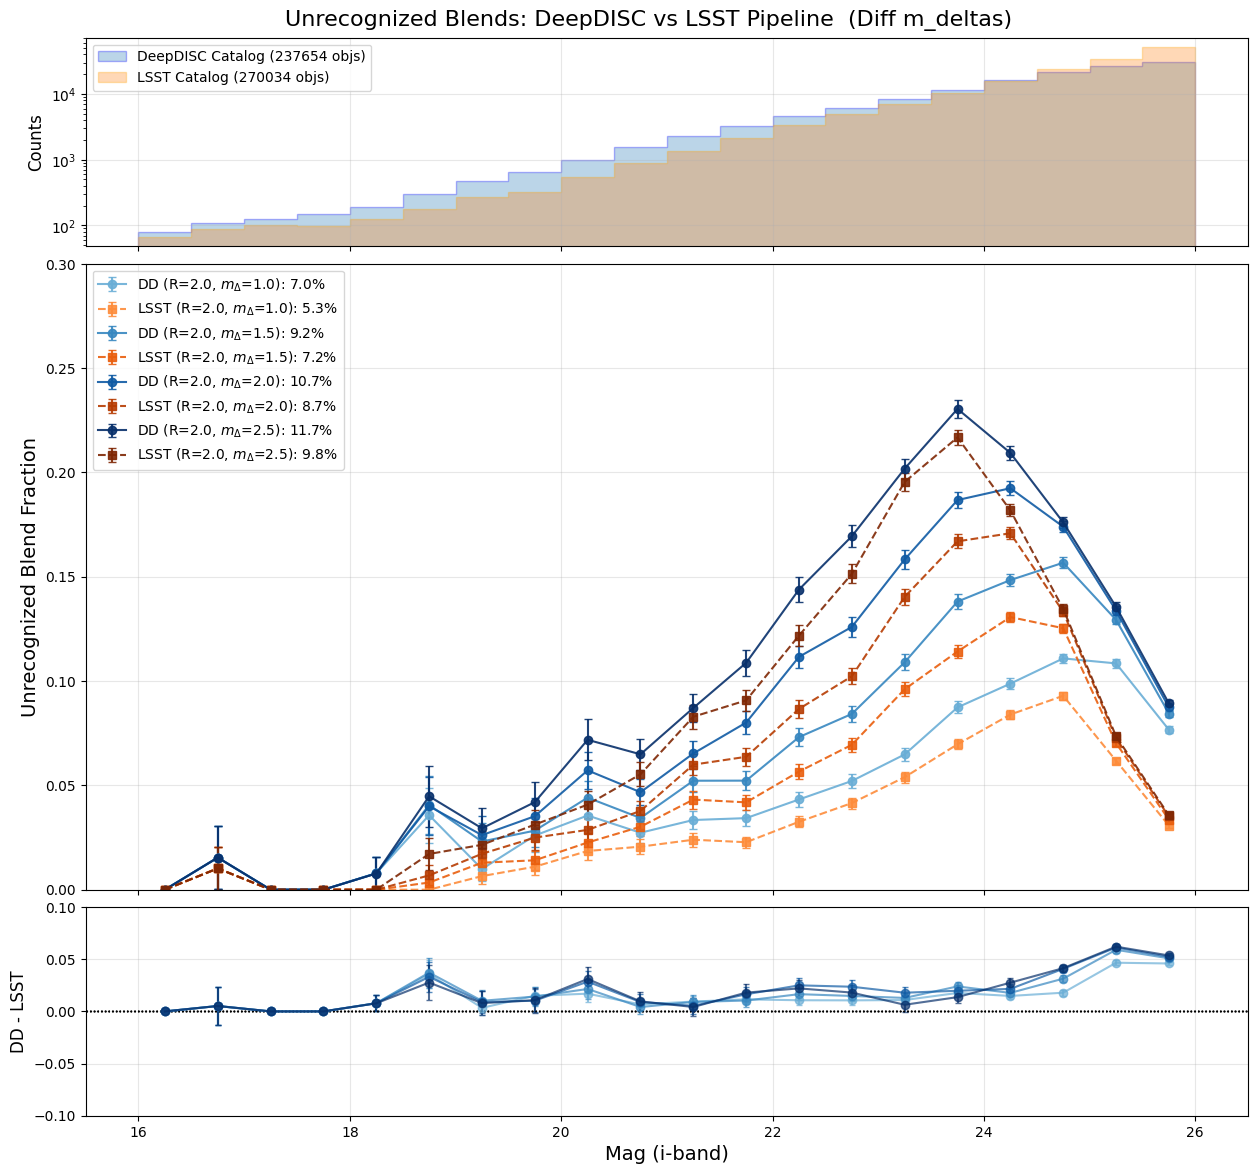

In [75]:
plot_comparison(results_m_deltas, dd_det_cat, lsst_det_cat, mag_bins, title_suffix=' (Diff m_deltas)')

## truth mag limit = 27.3

In [19]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)
results_rads = run_unrec_analysis_grid(dd_det_cat, lsst_det_cat, lsst_truth_cat,
                            radius_list=[0.5, 1.0, 2.0],
                            m_delta_list=[2.0],
                            mag_bins=mag_bins,
                            use_m_delta=True)

Calculating: R=0.5, m_delta=2.0...
DeepDISC: 2.05% (3933 / 191513)
LSST Pipeline: 2.40% (5043 / 210394)
DeepDISC Overall Unrec Blends: 3933
DeepDISC Overall Eligible: 191513
LSST Pipeline Overall Unrec Blends: 5043
LSST Pipeline Overall Eligible: 210394


--- Fractions per Magnitude Bin ---
Mag Center   | DeepDISC Frac   | LSST Pipe Frac 
------------------------------------------------
16.25        | 0.0000          | 0.0000         
16.75        | 0.0000          | 0.0000         
17.25        | 0.0000          | 0.0000         
17.75        | 0.0000          | 0.0000         
18.25        | 0.0000          | 0.0000         
18.75        | 0.0000          | 0.0000         
19.25        | 0.0045          | 0.0021         
19.75        | 0.0027          | 0.0061         
20.25        | 0.0163          | 0.0120         
20.75        | 0.0110          | 0.0100         
21.25        | 0.0111          | 0.0137         
21.75        | 0.0151          | 0.0157         
22.25        | 0.0149 

/tmp/ipykernel_3316062/1425525392.py:101: RuntimeWarning: invalid value encountered in divide
  diff = res['dd']['y']/res['lsst']['y']
/tmp/ipykernel_3316062/1425525392.py:101: RuntimeWarning: divide by zero encountered in divide
  diff = res['dd']['y']/res['lsst']['y']


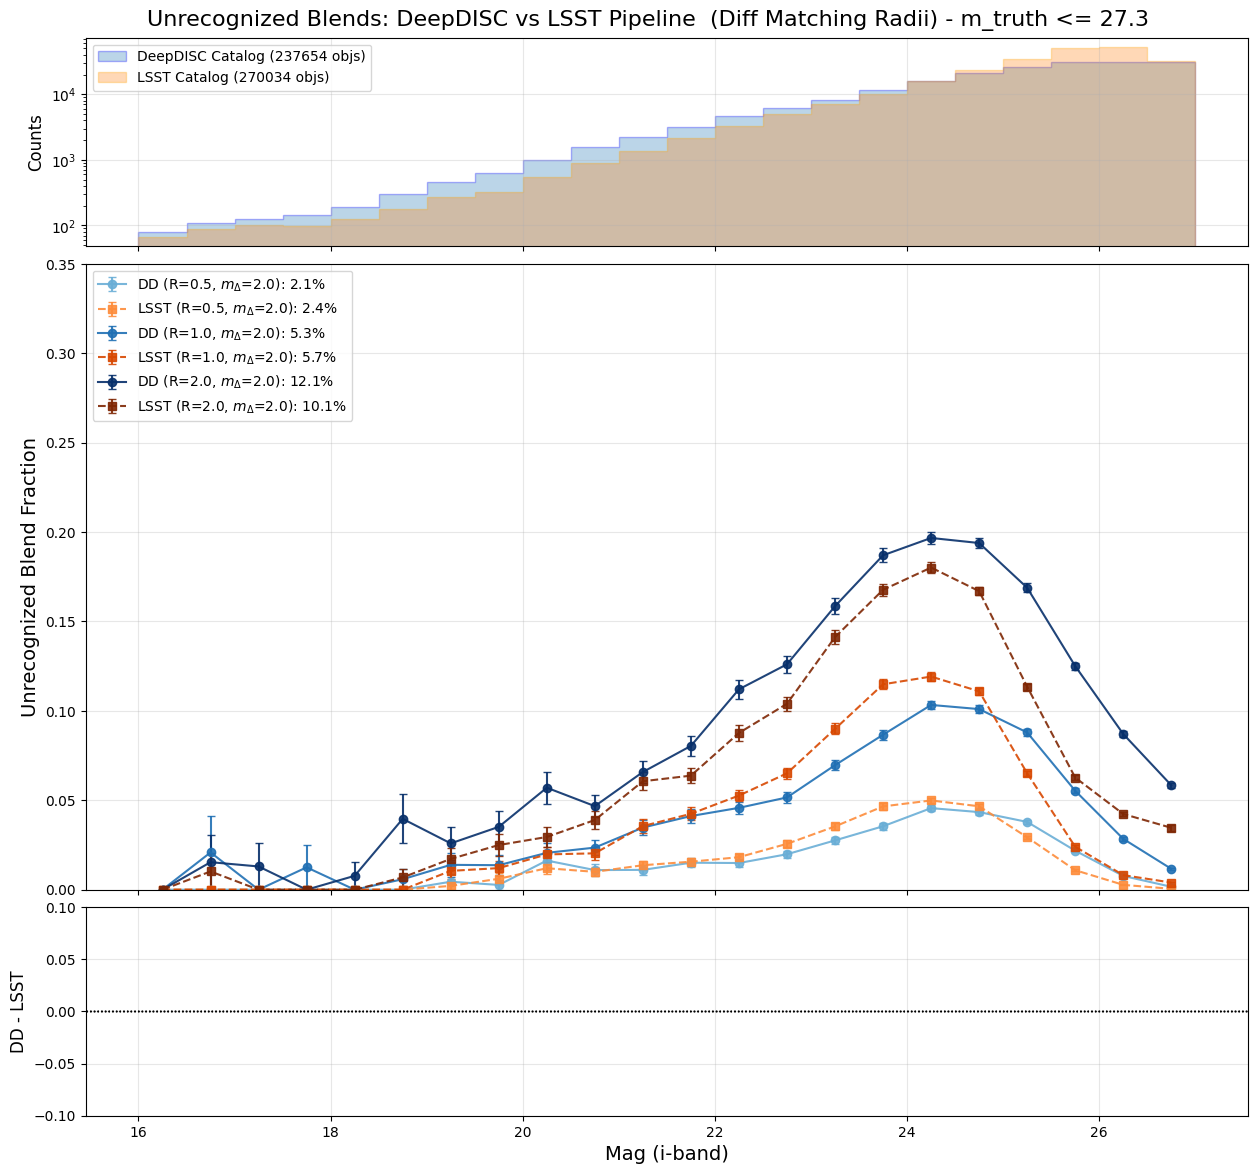

In [18]:
plot_comparison(results_rads, dd_det_cat, lsst_det_cat, mag_bins, title_suffix=' (Diff Matching Radii) - m_truth <= 27.3')

In [27]:
results_m_deltas = run_unrec_analysis_grid(dd_det_cat, lsst_det_cat, lsst_truth_cat,
                            radius_list=[2.0],
                            m_delta_list=[1.0, 1.5, 2.0, 2.5],
                            mag_bins=mag_bins,
                            use_m_delta=True)

Calculating: R=2.0, m_delta=1.0...
DeepDISC: 7.64% (14181 / 185629)
LSST Pipeline: 5.95% (11297 / 189963)
DeepDISC Overall Unrec Blends: 14181
DeepDISC Overall Eligible: 185629
LSST Pipeline Overall Unrec Blends: 11297
LSST Pipeline Overall Eligible: 189963

Calculating: R=2.0, m_delta=1.5...
DeepDISC: 10.23% (19518 / 190759)
LSST Pipeline: 8.27% (16209 / 195939)
DeepDISC Overall Unrec Blends: 19518
DeepDISC Overall Eligible: 190759
LSST Pipeline Overall Unrec Blends: 16209
LSST Pipeline Overall Eligible: 195939

Calculating: R=2.0, m_delta=2.0...
DeepDISC: 12.06% (23426 / 194309)
LSST Pipeline: 10.05% (20078 / 199701)
DeepDISC Overall Unrec Blends: 23426
DeepDISC Overall Eligible: 194309
LSST Pipeline Overall Unrec Blends: 20078
LSST Pipeline Overall Eligible: 199701

Calculating: R=2.0, m_delta=2.5...
DeepDISC: 13.27% (26113 / 196835)
LSST Pipeline: 11.43% (23045 / 201691)
DeepDISC Overall Unrec Blends: 26113
DeepDISC Overall Eligible: 196835
LSST Pipeline Overall Unrec Blends: 23045

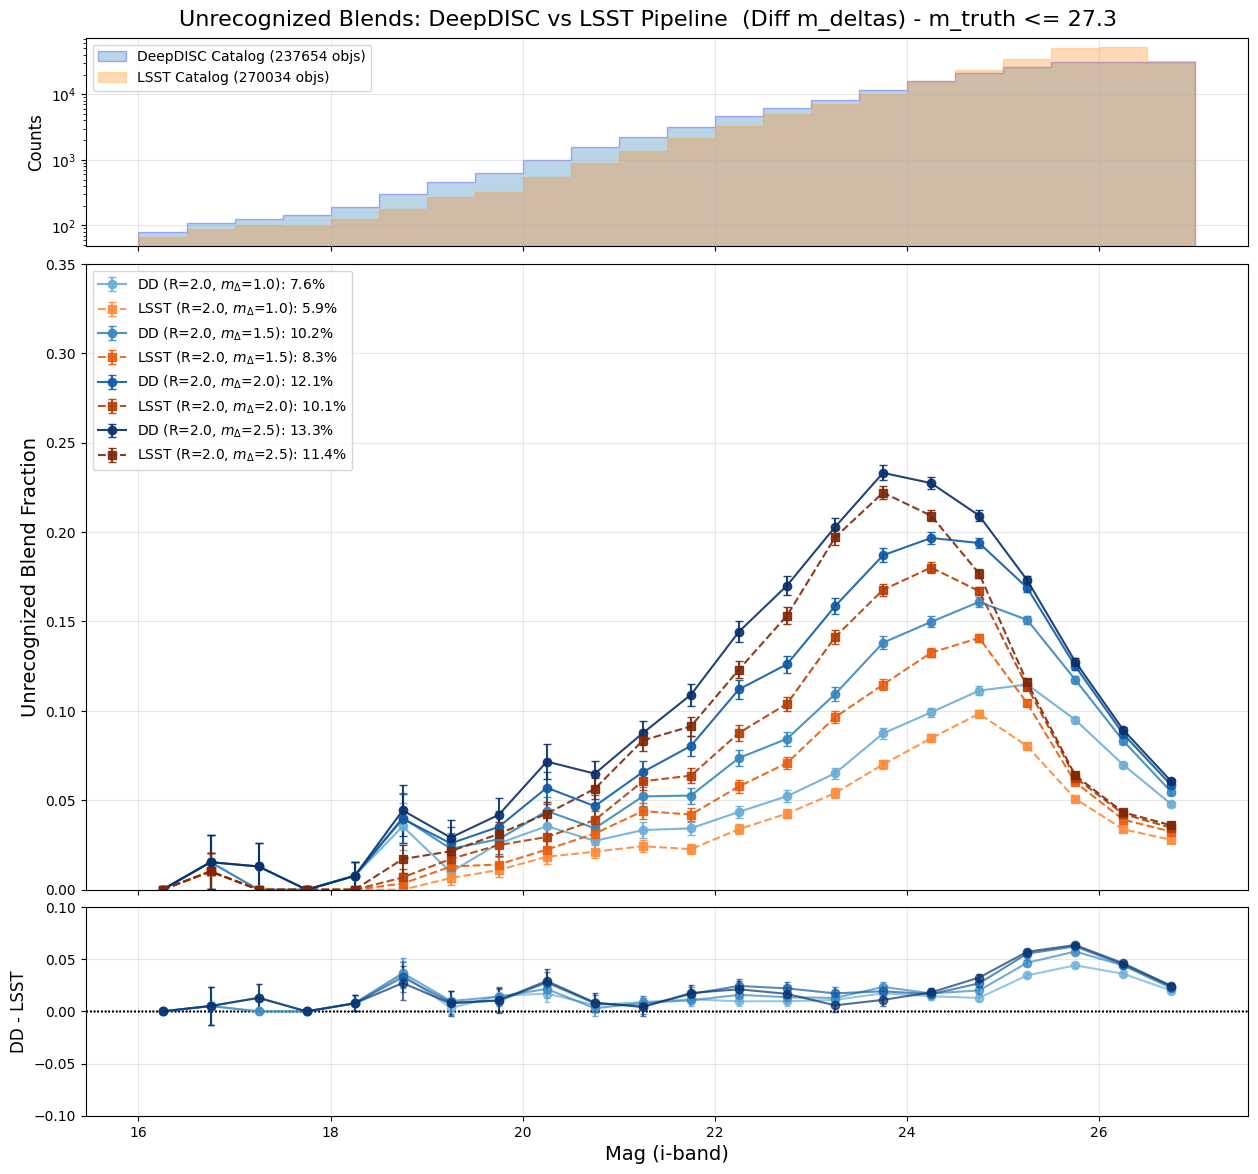

In [29]:
plot_comparison(results_m_deltas, dd_det_cat, lsst_det_cat, mag_bins, title_suffix=' (Diff m_deltas) - m_truth <= 27.3')